# Physics Constrained Autoencoders

By Mary Ye$^1$, Joshua C. Agar$^2$


$^1$ Department of Computer science and Engineering, Lehigh University
$^2$ Department of Mechanical Engineering and Mechanics, Drexel University

- There are many times where you want to fit spectroscopic data to a model


- Classical fitting methods can be used but break down:
  - When data is noisy
  - There are multiple candidate models
  - Data is high velocity
  - Data is noisy


## Imports Packages


In [1]:
!pip install m3_learning

In [2]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import time
import math

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator
from m3_learning.util.rand_util import rand_tensor, set_seeds

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

## Generating some data based on the image


### Define a non-linear function

<center> $$ y = A sin(2\theta f+ \phi)$$ </center>


In [3]:
class Sin_func:

    """
    Class that computes the Sin function
    """

    def __init__(
        self,
        x_vector,
        amp=[0, 1],
        phase=[0, 1],
        frequency=[0, 1],
        size=(1, 1),
        batch_size=1000,
        verbose=False,
    ):
        """

        Args:
            x_vector:
            sd (array, float): range for the standard deviation
            mean (array, float): range for the mean
            amp (array, float): range for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
        """

        self.x_vector = x_vector
        self.batch_size = batch_size

        self.amp = amp
        self.amp_mean = torch.tensor(amp[0] + amp[1]) / 2
        self.amp_sd = torch.sqrt(
            torch.pow(torch.tensor(amp[1]) - torch.tensor(amp[0]), 2) / 12
        )

        self.phase = phase
        self.phase_mean = torch.tensor(phase[0] + phase[1]) / 2
        self.phase_sd = torch.sqrt(
            torch.pow(torch.tensor(phase[1]) - torch.tensor(phase[0]), 2) / 12
        )

        self.frequency = frequency
        self.frequency_mean = torch.tensor(frequency[0] + frequency[1]) / 2
        self.frequency_sd = torch.sqrt(
            torch.pow(torch.tensor(frequency[1]) - torch.tensor(frequency[0]), 2) / 12
        )

        self.size = size
        self.verbose = verbose

    def compute(self, params, device="cpu"):
        """

        Args:
            self (object): Returns the instance itself.
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: out (Tensor): spectra.

        """

        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x_vector.shape[0], self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _amp = params[:, 0, 0, i]
                _phase = params[:, 0, 1, i]
                _frequency = params[:, 0, 2, i]

            if params.ndim == 3:
                _amp = params[:, 0, i]
                _phase = params[:, 1, i]
                _frequency = params[:, 2, i]

            x_vector = (
                torch.cat(params.shape[0] * [self.x_vector])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x_vector = torch.transpose(x_vector, 0, 1)  # .to(device)

            _out = _amp * torch.sin(
                2 * torch.tensor(np.pi) * _frequency * x_vector + _phase
            )

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self, device="cpu"):
        """

        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        phase = rand_tensor(
            min=self.phase[0],
            max=self.phase[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        frequency = rand_tensor(
            min=self.frequency[0],
            max=self.frequency[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        amp = rand_tensor(
            min=self.amp[0],
            max=self.amp[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )
        _params = torch.torch.stack((amp, phase, frequency))

        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)

        return (self.compute(_params, device=device), _params)

In [4]:
constructor = Sin_func(
    amp=[0.2, 1],  # Sets the amplitude
    phase=[0, 2 * np.pi],  # Sets the phase
    frequency=[0.1, 0.5],  # Sets the frequency
    x_vector=torch.linspace(0, np.pi, 100),  # Sets the x_vector
    batch_size=10000,
)  # number of samples to generate

In [5]:
# initializes the constructor
output = constructor.sampler()

# grabs the parameters and the spectra
spectra, params = output

# This grabs the sum of all spectral and the individual spectra if they exist
spectra_full, spectras = spectra

## Visualize examples


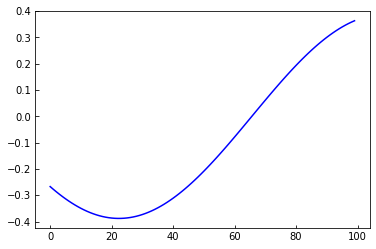

In [6]:
rand = np.random.randint(0, 10000)
plt.plot(spectras[rand, :, 0].cpu(), "b")


## Recurrent Neural Network Autoencoders

- It is important to consider the temporal domain
- This can be improved by using a recurrent neural network that processes each time step sequentially.
- To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.


![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)


![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)


### Builds the autoencoder


In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted


Since we know there are intrinsically 3 latent dimensions let's try and train the model.


In [9]:
device = "cuda"
latent_dim = 3

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [10]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

### Builds the dataloader


In [11]:
# constructs a dataloader for training

dataloader = DataLoader(spectra_full, batch_size=512, shuffle=True, num_workers=0)


In [12]:
# trains the model

torch.manual_seed(0)
Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  5%|████▏                                                                              | 1/20 [00:01<00:31,  1.65s/it]

 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  7.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:01<00:00, 16.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.76it/s]

Epoch 0, Train Loss: 0.2072
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.55it/s]

Epoch 1, Train Loss: 0.2068
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 2, Train Loss: 0.2066
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.00it/s]

Epoch 3, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.01it/s]

Epoch 4, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.01it/s]

Epoch 5, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.00it/s]

Epoch 6, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.50it/s]

Epoch 7, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 8, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.52it/s]

Epoch 9, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.01it/s]

Epoch 10, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 10/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 11, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 12, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.49it/s]

Epoch 13, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.48it/s]

Epoch 14, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 15, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.22it/s]

Epoch 16, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 17, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 18, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.43it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 92.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 19, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 10/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.01it/s]

Epoch 20, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.63it/s]

Epoch 21, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.01it/s]

Epoch 22, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.99it/s]

Epoch 23, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.14it/s]

Epoch 24, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 25, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 26, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.01it/s]

Epoch 27, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.53it/s]

Epoch 28, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 29, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.64it/s]

Epoch 30, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.10it/s]

Epoch 31, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.52it/s]

Epoch 32, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.57it/s]

Epoch 33, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.58it/s]

Epoch 34, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 35, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.97it/s]

Epoch 36, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.94it/s]

Epoch 37, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 38, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 39, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 40, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 41, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 42, Train Loss: 0.2051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.91it/s]

Epoch 43, Train Loss: 0.2047
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 44, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.22it/s]

Epoch 45, Train Loss: 0.2042
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 46, Train Loss: 0.2035
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.66it/s]

Epoch 47, Train Loss: 0.2028
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.72it/s]

Epoch 48, Train Loss: 0.2013
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 49, Train Loss: 0.2005
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.03it/s]

Epoch 50, Train Loss: 0.1995
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.03it/s]

Epoch 51, Train Loss: 0.1986
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 52, Train Loss: 0.1981
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.62it/s]

Epoch 53, Train Loss: 0.1974
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.71it/s]

Epoch 54, Train Loss: 0.1972
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

Epoch 55, Train Loss: 0.1970
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 56, Train Loss: 0.1968
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.68it/s]

Epoch 57, Train Loss: 0.1969
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.77it/s]

Epoch 58, Train Loss: 0.1970
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.61it/s]

Epoch 59, Train Loss: 0.1961
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 60, Train Loss: 0.1964
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 61, Train Loss: 0.1962
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.29it/s]

Epoch 62, Train Loss: 0.1963
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.35it/s]

Epoch 63, Train Loss: 0.1960
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 64, Train Loss: 0.1961
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.75it/s]

Epoch 65, Train Loss: 0.1961
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.17it/s]

Epoch 66, Train Loss: 0.1962
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 67, Train Loss: 0.1959
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 68, Train Loss: 0.1958
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.65it/s]

Epoch 69, Train Loss: 0.1957
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 70, Train Loss: 0.1956
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.36it/s]

Epoch 71, Train Loss: 0.1959
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.27it/s]

Epoch 72, Train Loss: 0.1957
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.49it/s]

Epoch 73, Train Loss: 0.1955
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 74, Train Loss: 0.1951
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.62it/s]

Epoch 75, Train Loss: 0.1956
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.67it/s]

Epoch 76, Train Loss: 0.1953
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 77, Train Loss: 0.1952
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.18it/s]

Epoch 78, Train Loss: 0.1952
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

Epoch 79, Train Loss: 0.1952
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 80, Train Loss: 0.1949
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.67it/s]

Epoch 81, Train Loss: 0.1948
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.41it/s]

Epoch 82, Train Loss: 0.1947
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.06it/s]

Epoch 83, Train Loss: 0.1948
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.12it/s]

Epoch 84, Train Loss: 0.1946
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.84it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.04it/s]

Epoch 85, Train Loss: 0.1945
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.03it/s]

Epoch 86, Train Loss: 0.1942
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.77it/s]

Epoch 87, Train Loss: 0.1939
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.30it/s]

Epoch 88, Train Loss: 0.1938
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.25it/s]

Epoch 89, Train Loss: 0.1934
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.06it/s]

Epoch 90, Train Loss: 0.1938
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.40it/s]

Epoch 91, Train Loss: 0.1937
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.43it/s]

Epoch 92, Train Loss: 0.1932
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.40it/s]

Epoch 93, Train Loss: 0.1934
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 94, Train Loss: 0.1930
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.62it/s]

Epoch 95, Train Loss: 0.1924
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.26it/s]

Epoch 96, Train Loss: 0.1921
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.51it/s]

Epoch 97, Train Loss: 0.1917
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.22it/s]

Epoch 98, Train Loss: 0.1914
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 99, Train Loss: 0.1912
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.93it/s]

Epoch 100, Train Loss: 0.1908
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.61it/s]

Epoch 101, Train Loss: 0.1905
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 102, Train Loss: 0.1898
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.75it/s]

Epoch 103, Train Loss: 0.1891
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 104, Train Loss: 0.1889
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.25it/s]

Epoch 105, Train Loss: 0.1883
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

Epoch 106, Train Loss: 0.1877
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.10it/s]

Epoch 107, Train Loss: 0.1872
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 108, Train Loss: 0.1867
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.00it/s]

Epoch 109, Train Loss: 0.1863
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 110, Train Loss: 0.1852
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.88it/s]

Epoch 111, Train Loss: 0.1847
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.01it/s]

Epoch 112, Train Loss: 0.1839
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.20it/s]

Epoch 113, Train Loss: 0.1822
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 114, Train Loss: 0.1815
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 115, Train Loss: 0.1806
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 116, Train Loss: 0.1798
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.27it/s]

Epoch 117, Train Loss: 0.1787
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 118, Train Loss: 0.1783
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.61it/s]

Epoch 119, Train Loss: 0.1776
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 120, Train Loss: 0.1774
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 121, Train Loss: 0.1763
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 122, Train Loss: 0.1756
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.42it/s]

Epoch 123, Train Loss: 0.1749
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.89it/s]

Epoch 124, Train Loss: 0.1742
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 74.79it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 81.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.92it/s]

Epoch 125, Train Loss: 0.1723
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 126, Train Loss: 0.1703
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 127, Train Loss: 0.1681
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.14it/s]

Epoch 128, Train Loss: 0.1647
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.26it/s]

Epoch 129, Train Loss: 0.1622
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.59it/s]

Epoch 130, Train Loss: 0.1606
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.48it/s]

Epoch 131, Train Loss: 0.1573
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 132, Train Loss: 0.1547
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 133, Train Loss: 0.1523
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.02it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.16it/s]

Epoch 134, Train Loss: 0.1499
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 135, Train Loss: 0.1487
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 136, Train Loss: 0.1489
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.87it/s]

Epoch 137, Train Loss: 0.1448
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.44it/s]

Epoch 138, Train Loss: 0.1442
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 139, Train Loss: 0.1423
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 140, Train Loss: 0.1416
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.77it/s]

Epoch 141, Train Loss: 0.1413
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.42it/s]

Epoch 142, Train Loss: 0.1406
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 143, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 144, Train Loss: 0.1390
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

Epoch 145, Train Loss: 0.1382
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.25it/s]

Epoch 146, Train Loss: 0.1377
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.23it/s]

Epoch 147, Train Loss: 0.1378
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 148, Train Loss: 0.1377
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.11it/s]

Epoch 149, Train Loss: 0.1367
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 150, Train Loss: 0.1360
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.05it/s]

Epoch 151, Train Loss: 0.1361
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.04it/s]

Epoch 152, Train Loss: 0.1354
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.80it/s]

Epoch 153, Train Loss: 0.1352
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 154, Train Loss: 0.1348
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.22it/s]

Epoch 155, Train Loss: 0.1349
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.59it/s]

Epoch 156, Train Loss: 0.1346
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.71it/s]

Epoch 157, Train Loss: 0.1346
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 158, Train Loss: 0.1341
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 159, Train Loss: 0.1348
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.07it/s]

Epoch 160, Train Loss: 0.1338
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 161, Train Loss: 0.1333
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 162, Train Loss: 0.1335
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 163, Train Loss: 0.1325
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.36it/s]

Epoch 164, Train Loss: 0.1326
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 165, Train Loss: 0.1324
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.24it/s]

Epoch 166, Train Loss: 0.1321
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.67it/s]

Epoch 167, Train Loss: 0.1320
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 78.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.65it/s]

Epoch 168, Train Loss: 0.1318
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.50it/s]

Epoch 169, Train Loss: 0.1312
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.32it/s]

Epoch 170, Train Loss: 0.1314
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.68it/s]

Epoch 171, Train Loss: 0.1309
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.12it/s]

Epoch 172, Train Loss: 0.1312
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.17it/s]

Epoch 173, Train Loss: 0.1305
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 174, Train Loss: 0.1308
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.35it/s]

Epoch 175, Train Loss: 0.1303
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.37it/s]

Epoch 176, Train Loss: 0.1300
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.64it/s]

Epoch 177, Train Loss: 0.1295
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.35it/s]

Epoch 178, Train Loss: 0.1293
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.61it/s]

Epoch 179, Train Loss: 0.1300
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 180, Train Loss: 0.1296
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.03it/s]

Epoch 181, Train Loss: 0.1288
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.11it/s]

Epoch 182, Train Loss: 0.1290
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.02it/s]

Epoch 183, Train Loss: 0.1285
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.98it/s]

Epoch 184, Train Loss: 0.1284
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.69it/s]

Epoch 185, Train Loss: 0.1283
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.04it/s]

Epoch 186, Train Loss: 0.1285
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.64it/s]

Epoch 187, Train Loss: 0.1281
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.06it/s]

Epoch 188, Train Loss: 0.1274
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

Epoch 189, Train Loss: 0.1275
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.03it/s]

Epoch 190, Train Loss: 0.1274
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 191, Train Loss: 0.1271
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 192, Train Loss: 0.1265
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.17it/s]

Epoch 193, Train Loss: 0.1270
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.88it/s]

Epoch 194, Train Loss: 0.1266
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.01it/s]

Epoch 195, Train Loss: 0.1265
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.88it/s]

Epoch 196, Train Loss: 0.1264
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.26it/s]

Epoch 197, Train Loss: 0.1259
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.86it/s]

Epoch 198, Train Loss: 0.1258
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.31it/s]

Epoch 199, Train Loss: 0.1259
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.28it/s]

Epoch 200, Train Loss: 0.1259
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.09it/s]

Epoch 201, Train Loss: 0.1253
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.33it/s]

Epoch 202, Train Loss: 0.1253
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.88it/s]

Epoch 203, Train Loss: 0.1248
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.31it/s]

Epoch 204, Train Loss: 0.1246
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.48it/s]

Epoch 205, Train Loss: 0.1246
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.34it/s]

Epoch 206, Train Loss: 0.1247
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 207, Train Loss: 0.1242
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.29it/s]

Epoch 208, Train Loss: 0.1244
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.75it/s]

Epoch 209, Train Loss: 0.1241
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 210, Train Loss: 0.1240
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.05it/s]

Epoch 211, Train Loss: 0.1238
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.60it/s]

Epoch 212, Train Loss: 0.1236
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.22it/s]

Epoch 213, Train Loss: 0.1239
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

Epoch 214, Train Loss: 0.1235
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.14it/s]

Epoch 215, Train Loss: 0.1233
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.87it/s]

Epoch 216, Train Loss: 0.1229
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.15it/s]

Epoch 217, Train Loss: 0.1231
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.74it/s]

Epoch 218, Train Loss: 0.1228
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 219, Train Loss: 0.1224
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.01it/s]

Epoch 220, Train Loss: 0.1227
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.30it/s]

Epoch 221, Train Loss: 0.1223
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 222, Train Loss: 0.1221
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 223, Train Loss: 0.1221
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.77it/s]

Epoch 224, Train Loss: 0.1222
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.19it/s]

Epoch 225, Train Loss: 0.1219
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.53it/s]

Epoch 226, Train Loss: 0.1223
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 227, Train Loss: 0.1216
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.73it/s]

Epoch 228, Train Loss: 0.1216
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 229, Train Loss: 0.1214
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.88it/s]

Epoch 230, Train Loss: 0.1213
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.48it/s]

Epoch 231, Train Loss: 0.1213
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.43it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 82.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.85it/s]

Epoch 232, Train Loss: 0.1211
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.74it/s]

Epoch 233, Train Loss: 0.1209
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.16it/s]

Epoch 234, Train Loss: 0.1209
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.35it/s]

Epoch 235, Train Loss: 0.1208
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.70it/s]

Epoch 236, Train Loss: 0.1206
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.42it/s]

Epoch 237, Train Loss: 0.1206
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.49it/s]

Epoch 238, Train Loss: 0.1203
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.23it/s]

Epoch 239, Train Loss: 0.1204
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.67it/s]

Epoch 240, Train Loss: 0.1200
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.73it/s]

Epoch 241, Train Loss: 0.1203
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.22it/s]

Epoch 242, Train Loss: 0.1204
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.71it/s]

Epoch 243, Train Loss: 0.1200
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.04it/s]

Epoch 244, Train Loss: 0.1197
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 245, Train Loss: 0.1196
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.05it/s]

Epoch 246, Train Loss: 0.1195
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.18it/s]

Epoch 247, Train Loss: 0.1196
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.57it/s]

Epoch 248, Train Loss: 0.1192
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.55it/s]

Epoch 249, Train Loss: 0.1193
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 250, Train Loss: 0.1195
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.65it/s]

Epoch 251, Train Loss: 0.1192
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.61it/s]

Epoch 252, Train Loss: 0.1191
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.89it/s]

Epoch 253, Train Loss: 0.1189
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.17it/s]

Epoch 254, Train Loss: 0.1192
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.73it/s]

Epoch 255, Train Loss: 0.1186
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.00it/s]

Epoch 256, Train Loss: 0.1185
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.20it/s]

Epoch 257, Train Loss: 0.1184
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.90it/s]

Epoch 258, Train Loss: 0.1185
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.24it/s]

Epoch 259, Train Loss: 0.1184
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.11it/s]

Epoch 260, Train Loss: 0.1187
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.21it/s]

Epoch 261, Train Loss: 0.1184
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.78it/s]

Epoch 262, Train Loss: 0.1179
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.56it/s]

Epoch 263, Train Loss: 0.1182
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.10it/s]

Epoch 264, Train Loss: 0.1178
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 265, Train Loss: 0.1177
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.08it/s]

Epoch 266, Train Loss: 0.1179
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 267, Train Loss: 0.1178
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.44it/s]

Epoch 268, Train Loss: 0.1181
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.57it/s]

Epoch 269, Train Loss: 0.1175
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.76it/s]

Epoch 270, Train Loss: 0.1174
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]

Epoch 271, Train Loss: 0.1176
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 272, Train Loss: 0.1173
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.67it/s]

Epoch 273, Train Loss: 0.1172
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.13it/s]

Epoch 274, Train Loss: 0.1170
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 275, Train Loss: 0.1176
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.64it/s]

Epoch 276, Train Loss: 0.1168
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 277, Train Loss: 0.1170
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.27it/s]

Epoch 278, Train Loss: 0.1167
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.68it/s]

Epoch 279, Train Loss: 0.1167
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.12it/s]

Epoch 280, Train Loss: 0.1164
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.92it/s]

Epoch 281, Train Loss: 0.1169
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.97it/s]

Epoch 282, Train Loss: 0.1165
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.43it/s]

Epoch 283, Train Loss: 0.1164
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.82it/s]

Epoch 284, Train Loss: 0.1166
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.70it/s]

Epoch 285, Train Loss: 0.1160
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.27it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.67it/s]

Epoch 286, Train Loss: 0.1163
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.33it/s]

Epoch 287, Train Loss: 0.1166
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.04it/s]

Epoch 288, Train Loss: 0.1161
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.99it/s]

Epoch 289, Train Loss: 0.1160
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.35it/s]

Epoch 290, Train Loss: 0.1161
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 291, Train Loss: 0.1162
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.01it/s]

Epoch 292, Train Loss: 0.1156
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.76it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 84.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.96it/s]

Epoch 293, Train Loss: 0.1159
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.82it/s]

Epoch 294, Train Loss: 0.1156
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.54it/s]

Epoch 295, Train Loss: 0.1157
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 296, Train Loss: 0.1162
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.22it/s]

Epoch 297, Train Loss: 0.1161
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.92it/s]

Epoch 298, Train Loss: 0.1156
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.74it/s]

Epoch 299, Train Loss: 0.1153
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.22it/s]

Epoch 300, Train Loss: 0.1152
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.88it/s]

Epoch 301, Train Loss: 0.1154
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.83it/s]

Epoch 302, Train Loss: 0.1152
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.51it/s]

Epoch 303, Train Loss: 0.1154
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.14it/s]

Epoch 304, Train Loss: 0.1149
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 305, Train Loss: 0.1150
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]

Epoch 306, Train Loss: 0.1148
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.28it/s]

Epoch 307, Train Loss: 0.1148
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.65it/s]

Epoch 308, Train Loss: 0.1148
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.77it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.45it/s]

Epoch 309, Train Loss: 0.1151
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.28it/s]

Epoch 310, Train Loss: 0.1146
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.09it/s]

Epoch 311, Train Loss: 0.1155
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.10it/s]

Epoch 312, Train Loss: 0.1152
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.83it/s]

Epoch 313, Train Loss: 0.1144
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.25it/s]

Epoch 314, Train Loss: 0.1145
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.06it/s]

Epoch 315, Train Loss: 0.1144
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.76it/s]

Epoch 316, Train Loss: 0.1142
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.77it/s]

Epoch 317, Train Loss: 0.1148
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.04it/s]

Epoch 318, Train Loss: 0.1145
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.83it/s]

Epoch 319, Train Loss: 0.1141
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.49it/s]

Epoch 320, Train Loss: 0.1141
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.54it/s]

Epoch 321, Train Loss: 0.1141
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.73it/s]

Epoch 322, Train Loss: 0.1139
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.60it/s]

Epoch 323, Train Loss: 0.1139
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.05it/s]

Epoch 324, Train Loss: 0.1139
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.27it/s]

Epoch 325, Train Loss: 0.1137
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.83it/s]

Epoch 326, Train Loss: 0.1138
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.91it/s]

Epoch 327, Train Loss: 0.1140
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.86it/s]

Epoch 328, Train Loss: 0.1137
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.67it/s]

Epoch 329, Train Loss: 0.1138
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.27it/s]

Epoch 330, Train Loss: 0.1134
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.07it/s]

Epoch 331, Train Loss: 0.1131
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.70it/s]

Epoch 332, Train Loss: 0.1142
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.32it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.21it/s]

Epoch 333, Train Loss: 0.1138
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.98it/s]

Epoch 334, Train Loss: 0.1133
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.54it/s]

Epoch 335, Train Loss: 0.1132
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.74it/s]

Epoch 336, Train Loss: 0.1134
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.23it/s]

Epoch 337, Train Loss: 0.1138
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.22it/s]

Epoch 338, Train Loss: 0.1133
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.49it/s]

Epoch 339, Train Loss: 0.1130
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.80it/s]

Epoch 340, Train Loss: 0.1131
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 78.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.56it/s]

Epoch 341, Train Loss: 0.1132
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.88it/s]

Epoch 342, Train Loss: 0.1130
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.26it/s]

Epoch 343, Train Loss: 0.1128
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.05it/s]

Epoch 344, Train Loss: 0.1134
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.75it/s]

Epoch 345, Train Loss: 0.1128
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.10it/s]

Epoch 346, Train Loss: 0.1124
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.49it/s]

Epoch 347, Train Loss: 0.1127
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.83it/s]

Epoch 348, Train Loss: 0.1128
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.08it/s]

Epoch 349, Train Loss: 0.1126
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 350, Train Loss: 0.1122
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.20it/s]

Epoch 351, Train Loss: 0.1122
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.29it/s]

Epoch 352, Train Loss: 0.1125
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 353, Train Loss: 0.1125
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 354, Train Loss: 0.1124
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.61it/s]

Epoch 355, Train Loss: 0.1122
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 356, Train Loss: 0.1123
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.28it/s]

Epoch 357, Train Loss: 0.1120
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.13it/s]

Epoch 358, Train Loss: 0.1120
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.42it/s]

Epoch 359, Train Loss: 0.1124
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.35it/s]

Epoch 360, Train Loss: 0.1122
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.55it/s]

Epoch 361, Train Loss: 0.1126
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.64it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.58it/s]

Epoch 362, Train Loss: 0.1118
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.20it/s]

Epoch 363, Train Loss: 0.1119
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.43it/s]

Epoch 364, Train Loss: 0.1115
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.74it/s]

Epoch 365, Train Loss: 0.1119
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.90it/s]

Epoch 366, Train Loss: 0.1115
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.01it/s]

Epoch 367, Train Loss: 0.1118
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.29it/s]

Epoch 368, Train Loss: 0.1119
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.68it/s]

Epoch 369, Train Loss: 0.1114
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.44it/s]

Epoch 370, Train Loss: 0.1112
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.99it/s]

Epoch 371, Train Loss: 0.1118
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.05it/s]

Epoch 372, Train Loss: 0.1118
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.11it/s]

Epoch 373, Train Loss: 0.1112
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.35it/s]

Epoch 374, Train Loss: 0.1110
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.94it/s]

Epoch 375, Train Loss: 0.1110
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.66it/s]

Epoch 376, Train Loss: 0.1112
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 377, Train Loss: 0.1110
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.75it/s]

Epoch 378, Train Loss: 0.1112
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.27it/s]

Epoch 379, Train Loss: 0.1110
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.96it/s]

Epoch 380, Train Loss: 0.1107
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.80it/s]

Epoch 381, Train Loss: 0.1110
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 382, Train Loss: 0.1108
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.53it/s]

Epoch 383, Train Loss: 0.1107
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 384, Train Loss: 0.1107
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.27it/s]

Epoch 385, Train Loss: 0.1104
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

Epoch 386, Train Loss: 0.1108
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.07it/s]

Epoch 387, Train Loss: 0.1105
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.17it/s]

Epoch 388, Train Loss: 0.1118
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.53it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.49it/s]

Epoch 389, Train Loss: 0.1110
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.76it/s]

Epoch 390, Train Loss: 0.1100
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.22it/s]

Epoch 391, Train Loss: 0.1104
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.68it/s]

Epoch 392, Train Loss: 0.1103
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.55it/s]

Epoch 393, Train Loss: 0.1102
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.25it/s]

Epoch 394, Train Loss: 0.1102
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.33it/s]

Epoch 395, Train Loss: 0.1103
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 396, Train Loss: 0.1099
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.89it/s]

Epoch 397, Train Loss: 0.1103
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 398, Train Loss: 0.1099
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.14it/s]

Epoch 399, Train Loss: 0.1096
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 400, Train Loss: 0.1097
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 401, Train Loss: 0.1101
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]

Epoch 402, Train Loss: 0.1099
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

Epoch 403, Train Loss: 0.1096
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 404, Train Loss: 0.1098
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.05it/s]

Epoch 405, Train Loss: 0.1093
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 406, Train Loss: 0.1095
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 407, Train Loss: 0.1090
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 408, Train Loss: 0.1092
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.10it/s]

Epoch 409, Train Loss: 0.1090
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.26it/s]

Epoch 410, Train Loss: 0.1098
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.74it/s]

Epoch 411, Train Loss: 0.1093
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 412, Train Loss: 0.1093
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 413, Train Loss: 0.1093
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 81.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 83.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 414, Train Loss: 0.1089
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.28it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.48it/s]

Epoch 415, Train Loss: 0.1090
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 416, Train Loss: 0.1093
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.81it/s]

Epoch 417, Train Loss: 0.1096
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 78.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.96it/s]

Epoch 418, Train Loss: 0.1089
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 25%|████████████████████▊                                                              | 5/20 [00:00<00:00, 42.00it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 42.86it/s]

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:00<00:00, 42.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 42.34it/s]

Epoch 419, Train Loss: 0.1089
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 30%|████████████████████████▉                                                          | 6/20 [00:00<00:00, 51.26it/s]

 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:00<00:00, 45.72it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 42.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 44.82it/s]

Epoch 420, Train Loss: 0.1086
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 4/20 [00:00<00:00, 33.60it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 39.94it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 55.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 53.64it/s]

Epoch 421, Train Loss: 0.1087
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 422, Train Loss: 0.1089
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.93it/s]

Epoch 423, Train Loss: 0.1086
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 424, Train Loss: 0.1089
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 425, Train Loss: 0.1086
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.23it/s]

Epoch 426, Train Loss: 0.1083
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 427, Train Loss: 0.1084
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.91it/s]

Epoch 428, Train Loss: 0.1083
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.89it/s]

Epoch 429, Train Loss: 0.1083
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 430, Train Loss: 0.1084
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 431, Train Loss: 0.1081
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 432, Train Loss: 0.1083
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.02it/s]

Epoch 433, Train Loss: 0.1080
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.22it/s]

Epoch 434, Train Loss: 0.1082
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.90it/s]

Epoch 435, Train Loss: 0.1077
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.04it/s]

Epoch 436, Train Loss: 0.1080
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 437, Train Loss: 0.1081
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 438, Train Loss: 0.1077
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.29it/s]

Epoch 439, Train Loss: 0.1077
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 440, Train Loss: 0.1074
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.22it/s]

Epoch 441, Train Loss: 0.1073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 442, Train Loss: 0.1074
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.35it/s]

Epoch 443, Train Loss: 0.1075
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

Epoch 444, Train Loss: 0.1073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 445, Train Loss: 0.1074
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.83it/s]

Epoch 446, Train Loss: 0.1073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.76it/s]

Epoch 447, Train Loss: 0.1073
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 448, Train Loss: 0.1069
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.81it/s]

Epoch 449, Train Loss: 0.1072
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 450, Train Loss: 0.1069
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 451, Train Loss: 0.1065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 452, Train Loss: 0.1068
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.44it/s]

Epoch 453, Train Loss: 0.1072
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.77it/s]

Epoch 454, Train Loss: 0.1068
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.23it/s]

Epoch 455, Train Loss: 0.1074
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.80it/s]

Epoch 456, Train Loss: 0.1071
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 457, Train Loss: 0.1066
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 458, Train Loss: 0.1063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.56it/s]

Epoch 459, Train Loss: 0.1065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.28it/s]

Epoch 460, Train Loss: 0.1065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.43it/s]

Epoch 461, Train Loss: 0.1064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.60it/s]

Epoch 462, Train Loss: 0.1060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 463, Train Loss: 0.1062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 464, Train Loss: 0.1065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.40it/s]

Epoch 465, Train Loss: 0.1063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 466, Train Loss: 0.1063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.77it/s]

Epoch 467, Train Loss: 0.1059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.50it/s]

Epoch 468, Train Loss: 0.1059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 469, Train Loss: 0.1054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.35it/s]

Epoch 470, Train Loss: 0.1057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.21it/s]

Epoch 471, Train Loss: 0.1054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 472, Train Loss: 0.1056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.01it/s]

Epoch 473, Train Loss: 0.1055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.70it/s]

Epoch 474, Train Loss: 0.1054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.70it/s]

Epoch 475, Train Loss: 0.1051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 476, Train Loss: 0.1057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.17it/s]

Epoch 477, Train Loss: 0.1055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 88.52it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 85.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.99it/s]

Epoch 478, Train Loss: 0.1056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.59it/s]

Epoch 479, Train Loss: 0.1054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.00it/s]

Epoch 480, Train Loss: 0.1062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]

Epoch 481, Train Loss: 0.1051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 482, Train Loss: 0.1047
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.59it/s]

Epoch 483, Train Loss: 0.1046
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 484, Train Loss: 0.1050
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.67it/s]

Epoch 485, Train Loss: 0.1049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.35it/s]

Epoch 486, Train Loss: 0.1046
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.70it/s]

Epoch 487, Train Loss: 0.1046
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.10it/s]

Epoch 488, Train Loss: 0.1050
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 489, Train Loss: 0.1048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 490, Train Loss: 0.1047
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 491, Train Loss: 0.1051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.01it/s]

Epoch 492, Train Loss: 0.1048
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 493, Train Loss: 0.1047
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 494, Train Loss: 0.1041
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 495, Train Loss: 0.1040
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.11it/s]

Epoch 496, Train Loss: 0.1038
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 497, Train Loss: 0.1039
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 498, Train Loss: 0.1041
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.96it/s]

Epoch 499, Train Loss: 0.1036
.............................


## Visualize the reconstruction


In [13]:
# computes an example reconstruction for a mini batch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


C:\Conda\lib\site-packages\m3_learning\nn\time_series_nn\nn_util.py:294: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))


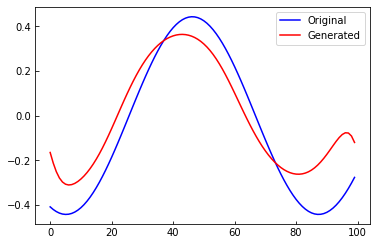

In [14]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


## Generating Validation Data

- We want to generate a hyperspectral image
- This can be done by taking the RGB values of an image and using them as parameters for a function


### Loads and image of my dog Nala

- Painting by _Irene Dogmatic_


In [15]:
# Loads dog image

image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image

image = image[200:1900:20, 100:1500:20] / 255

### Displays the image


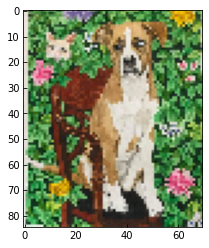

In [16]:
plt.imshow(image)

### Generates the data from RGB sampling


In [17]:
# Converts the image into parameters within the generated range

nala_params = np.atleast_3d(image.reshape(-1, 3))

nala_amp = torch.tensor(nala_params[:, 0, 0] * 0.8 + 0.2)
nala_phase = torch.tensor(nala_params[:, 1, 0] * 2 * np.pi)
nala_frequency = torch.tensor(nala_params[:, 2, 0] * 0.5 + 0.1)

_nala_params = torch.torch.stack((nala_amp, nala_phase, nala_frequency))

_nala_params = torch.atleast_3d(_nala_params)
_nala_params = torch.transpose(_nala_params, 0, 1)


In [18]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


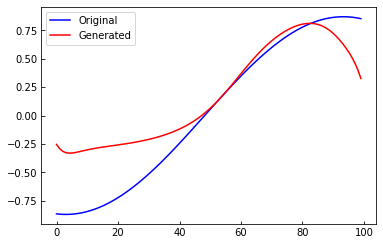

In [19]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


### Visualize the learned results


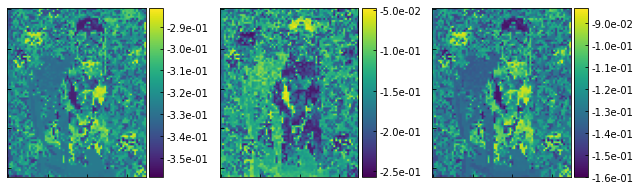

In [20]:
# Visualize the learned embeddings

embedding_maps(nala_encoded_, image)

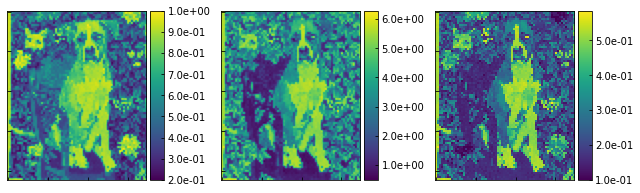

In [21]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


- **There is minimal resemblance to the true features**

- This is unsurprising because there are no rules that define what the embedding should look like.


## Let's try a bigger model

### Builds the model


In [22]:
device = "cuda"
latent_dim = 12

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [23]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

## Training


In [24]:
# trains the model

torch.manual_seed(0)
Train(
    model, encoder, decoder, dataloader, optimizer, 500,
)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 0, Train Loss: 0.2137
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 1, Train Loss: 0.2124
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.11it/s]

Epoch 2, Train Loss: 0.2114
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.21it/s]

Epoch 3, Train Loss: 0.2102
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 73.39it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 81.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 4, Train Loss: 0.2092
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.69it/s]

Epoch 5, Train Loss: 0.2083
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.61it/s]

Epoch 6, Train Loss: 0.2079
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.58it/s]

Epoch 7, Train Loss: 0.2074
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 10/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.57it/s]

Epoch 8, Train Loss: 0.2070
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 9, Train Loss: 0.2068
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 10, Train Loss: 0.2067
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 11, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.58it/s]

Epoch 12, Train Loss: 0.2066
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.25it/s]

Epoch 13, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.32it/s]

Epoch 14, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.60it/s]

Epoch 15, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.03it/s]

Epoch 16, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.67it/s]

Epoch 17, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.69it/s]

Epoch 18, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.46it/s]

Epoch 19, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.40it/s]

Epoch 20, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.13it/s]

Epoch 21, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.08it/s]

Epoch 22, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.82it/s]

Epoch 23, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.03it/s]

Epoch 24, Train Loss: 0.2065
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.09it/s]

Epoch 25, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.72it/s]

Epoch 26, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 27, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.06it/s]

Epoch 28, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 29, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.70it/s]

Epoch 30, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.64it/s]

Epoch 31, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.81it/s]

Epoch 32, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.95it/s]

Epoch 33, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.14it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.29it/s]

Epoch 34, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.54it/s]

Epoch 35, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.10it/s]

Epoch 36, Train Loss: 0.2067
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.69it/s]

Epoch 37, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.61it/s]

Epoch 38, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 39, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.46it/s]

Epoch 40, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.83it/s]

Epoch 41, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.01it/s]

Epoch 42, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.66it/s]

Epoch 43, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.58it/s]

Epoch 44, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 45, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 46, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 47, Train Loss: 0.2064
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.92it/s]

Epoch 48, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.15it/s]

Epoch 49, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 50, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.00it/s]

Epoch 51, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 10/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 52, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.24it/s]

Epoch 53, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 54, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 55, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.15it/s]

Epoch 56, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.17it/s]

Epoch 57, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 58, Train Loss: 0.2066
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.62it/s]

Epoch 59, Train Loss: 0.2058
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 60, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 61, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.62it/s]

Epoch 62, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.53it/s]

Epoch 63, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 90.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 64, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.11it/s]

Epoch 65, Train Loss: 0.2061
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

Epoch 66, Train Loss: 0.2063
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 67, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 75.46it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 82.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.30it/s]

Epoch 68, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 69, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 70, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.09it/s]

Epoch 71, Train Loss: 0.2062
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.68it/s]

Epoch 72, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.54it/s]

Epoch 73, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.43it/s]

Epoch 74, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 75, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.74it/s]

Epoch 76, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 99.02it/s]

Epoch 77, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.47it/s]

Epoch 78, Train Loss: 0.2060
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 79, Train Loss: 0.2059
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.75it/s]

Epoch 80, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 81, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

Epoch 82, Train Loss: 0.2056
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.01it/s]

Epoch 83, Train Loss: 0.2057
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 84, Train Loss: 0.2054
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.44it/s]

Epoch 85, Train Loss: 0.2055
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.90it/s]

Epoch 86, Train Loss: 0.2051
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 87, Train Loss: 0.2049
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 88, Train Loss: 0.2047
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 89, Train Loss: 0.2042
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 90, Train Loss: 0.2043
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.26it/s]

Epoch 91, Train Loss: 0.2040
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 92, Train Loss: 0.2033
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.14it/s]

Epoch 93, Train Loss: 0.2031
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.46it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.25it/s]

Epoch 94, Train Loss: 0.2021
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.96it/s]

Epoch 95, Train Loss: 0.2007
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 96, Train Loss: 0.1996
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 97, Train Loss: 0.1984
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.07it/s]

Epoch 98, Train Loss: 0.1975
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 99, Train Loss: 0.1972
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.93it/s]

Epoch 100, Train Loss: 0.1968
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 92.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

Epoch 101, Train Loss: 0.1968
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 102, Train Loss: 0.1964
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.53it/s]

Epoch 103, Train Loss: 0.1963
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 104, Train Loss: 0.1964
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 105, Train Loss: 0.1961
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 106, Train Loss: 0.1959
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.03it/s]

Epoch 107, Train Loss: 0.1959
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.89it/s]

Epoch 108, Train Loss: 0.1959
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.94it/s]

Epoch 109, Train Loss: 0.1960
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.54it/s]

Epoch 110, Train Loss: 0.1957
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 111, Train Loss: 0.1960
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 112, Train Loss: 0.1960
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 113, Train Loss: 0.1953
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 114, Train Loss: 0.1956
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.04it/s]

Epoch 115, Train Loss: 0.1956
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.40it/s]

Epoch 116, Train Loss: 0.1955
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.29it/s]

Epoch 117, Train Loss: 0.1950
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.44it/s]

Epoch 118, Train Loss: 0.1950
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.24it/s]

Epoch 119, Train Loss: 0.1948
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 120, Train Loss: 0.1950
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 121, Train Loss: 0.1945
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▌                                    | 11/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.18it/s]

Epoch 122, Train Loss: 0.1941
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 123, Train Loss: 0.1941
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 124, Train Loss: 0.1944
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 125, Train Loss: 0.1937
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 126, Train Loss: 0.1937
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.50it/s]

Epoch 127, Train Loss: 0.1936
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 80.00it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 82.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.65it/s]

Epoch 128, Train Loss: 0.1932
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.07it/s]

Epoch 129, Train Loss: 0.1930
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.33it/s]

Epoch 130, Train Loss: 0.1931
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 131, Train Loss: 0.1922
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.05it/s]

Epoch 132, Train Loss: 0.1917
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.47it/s]

Epoch 133, Train Loss: 0.1910
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.70it/s]

Epoch 134, Train Loss: 0.1902
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.31it/s]

Epoch 135, Train Loss: 0.1893
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.46it/s]

Epoch 136, Train Loss: 0.1882
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.53it/s]

Epoch 137, Train Loss: 0.1866
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.61it/s]

Epoch 138, Train Loss: 0.1854
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 139, Train Loss: 0.1840
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.33it/s]

Epoch 140, Train Loss: 0.1831
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 141, Train Loss: 0.1828
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 142, Train Loss: 0.1818
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.09it/s]

Epoch 143, Train Loss: 0.1813
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 79.99it/s]

Epoch 144, Train Loss: 0.1811
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 71.43it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 74.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 75.47it/s]

Epoch 145, Train Loss: 0.1807
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 92.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.89it/s]

Epoch 146, Train Loss: 0.1803
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.77it/s]

Epoch 147, Train Loss: 0.1802
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 148, Train Loss: 0.1801
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 149, Train Loss: 0.1800
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.22it/s]

Epoch 150, Train Loss: 0.1793
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.12it/s]

Epoch 151, Train Loss: 0.1796
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 11/20 [00:00<00:00, 99.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 152, Train Loss: 0.1790
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.75it/s]

Epoch 153, Train Loss: 0.1791
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.64it/s]

Epoch 154, Train Loss: 0.1790
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.46it/s]

Epoch 155, Train Loss: 0.1787
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.50it/s]

Epoch 156, Train Loss: 0.1788
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 157, Train Loss: 0.1790
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.00it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.65it/s]

Epoch 158, Train Loss: 0.1781
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.54it/s]

Epoch 159, Train Loss: 0.1783
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.55it/s]

Epoch 160, Train Loss: 0.1784
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 161, Train Loss: 0.1777
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 162, Train Loss: 0.1778
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 163, Train Loss: 0.1772
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.90it/s]

Epoch 164, Train Loss: 0.1777
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.57it/s]

Epoch 165, Train Loss: 0.1773
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.99it/s]

Epoch 166, Train Loss: 0.1769
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 167, Train Loss: 0.1770
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 168, Train Loss: 0.1773
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 169, Train Loss: 0.1767
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 170, Train Loss: 0.1767
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.05it/s]

Epoch 171, Train Loss: 0.1765
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.96it/s]

Epoch 172, Train Loss: 0.1764
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.96it/s]

Epoch 173, Train Loss: 0.1761
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.55it/s]

Epoch 174, Train Loss: 0.1764
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.26it/s]

Epoch 175, Train Loss: 0.1761
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.17it/s]

Epoch 176, Train Loss: 0.1760
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.59it/s]

Epoch 177, Train Loss: 0.1759
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.93it/s]

Epoch 178, Train Loss: 0.1755
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.01it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.09it/s]

Epoch 179, Train Loss: 0.1756
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.63it/s]

Epoch 180, Train Loss: 0.1753
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.75it/s]

Epoch 181, Train Loss: 0.1751
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.93it/s]

Epoch 182, Train Loss: 0.1754
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.13it/s]

Epoch 183, Train Loss: 0.1749
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 184, Train Loss: 0.1748
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.51it/s]

Epoch 185, Train Loss: 0.1747
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 186, Train Loss: 0.1744
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 187, Train Loss: 0.1746
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 188, Train Loss: 0.1738
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.53it/s]

Epoch 189, Train Loss: 0.1739
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 190, Train Loss: 0.1738
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 98.04it/s]

Epoch 191, Train Loss: 0.1733
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.31it/s]

Epoch 192, Train Loss: 0.1725
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.35it/s]

Epoch 193, Train Loss: 0.1723
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.34it/s]

Epoch 194, Train Loss: 0.1719
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.85it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.56it/s]

Epoch 195, Train Loss: 0.1711
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.70it/s]

Epoch 196, Train Loss: 0.1703
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 197, Train Loss: 0.1687
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.33it/s]

Epoch 198, Train Loss: 0.1679
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 199, Train Loss: 0.1666
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 200, Train Loss: 0.1655
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.00it/s]

Epoch 201, Train Loss: 0.1645
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.41it/s]

Epoch 202, Train Loss: 0.1640
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.88it/s]

Epoch 203, Train Loss: 0.1636
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.16it/s]

Epoch 204, Train Loss: 0.1632
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 205, Train Loss: 0.1618
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.89it/s]

Epoch 206, Train Loss: 0.1612
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

Epoch 207, Train Loss: 0.1605
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 208, Train Loss: 0.1594
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 90.00it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 90.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.22it/s]

Epoch 209, Train Loss: 0.1590
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 210, Train Loss: 0.1583
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 211, Train Loss: 0.1574
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 212, Train Loss: 0.1567
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.81it/s]

Epoch 213, Train Loss: 0.1562
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 214, Train Loss: 0.1566
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 215, Train Loss: 0.1551
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.91it/s]

Epoch 216, Train Loss: 0.1545
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.98it/s]

Epoch 217, Train Loss: 0.1541
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 218, Train Loss: 0.1539
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 219, Train Loss: 0.1537
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.61it/s]

Epoch 220, Train Loss: 0.1541
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.60it/s]

Epoch 221, Train Loss: 0.1532
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 222, Train Loss: 0.1532
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 223, Train Loss: 0.1526
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 224, Train Loss: 0.1531
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.73it/s]

Epoch 225, Train Loss: 0.1522
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.81it/s]

Epoch 226, Train Loss: 0.1522
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 227, Train Loss: 0.1516
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.45it/s]

Epoch 228, Train Loss: 0.1517
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

Epoch 229, Train Loss: 0.1522
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 230, Train Loss: 0.1515
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.60it/s]

Epoch 231, Train Loss: 0.1513
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.17it/s]

Epoch 232, Train Loss: 0.1512
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 233, Train Loss: 0.1508
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 234, Train Loss: 0.1509
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 235, Train Loss: 0.1515
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 236, Train Loss: 0.1509
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.18it/s]

Epoch 237, Train Loss: 0.1514
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.65it/s]

Epoch 238, Train Loss: 0.1500
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 239, Train Loss: 0.1500
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 240, Train Loss: 0.1498
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 241, Train Loss: 0.1499
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.04it/s]

Epoch 242, Train Loss: 0.1503
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 243, Train Loss: 0.1499
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.63it/s]

Epoch 244, Train Loss: 0.1496
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 245, Train Loss: 0.1494
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.29it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 86.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.34it/s]

Epoch 246, Train Loss: 0.1494
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 247, Train Loss: 0.1494
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

Epoch 248, Train Loss: 0.1492
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 249, Train Loss: 0.1495
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 250, Train Loss: 0.1489
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

Epoch 251, Train Loss: 0.1490
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 252, Train Loss: 0.1485
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 253, Train Loss: 0.1490
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.23it/s]

Epoch 254, Train Loss: 0.1485
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.45it/s]

Epoch 255, Train Loss: 0.1483
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 256, Train Loss: 0.1485
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.18it/s]

Epoch 257, Train Loss: 0.1486
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 89.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.69it/s]

Epoch 258, Train Loss: 0.1484
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.09it/s]

Epoch 259, Train Loss: 0.1482
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.21it/s]

Epoch 260, Train Loss: 0.1482
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.01it/s]

Epoch 261, Train Loss: 0.1480
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.65it/s]

Epoch 262, Train Loss: 0.1479
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.43it/s]

Epoch 263, Train Loss: 0.1478
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 81.06it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 264, Train Loss: 0.1477
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.26it/s]

Epoch 265, Train Loss: 0.1478
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.93it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 76.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 78.02it/s]

Epoch 266, Train Loss: 0.1477
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.07it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 75.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 77.16it/s]

Epoch 267, Train Loss: 0.1476
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 72.71it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 74.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 75.25it/s]

Epoch 268, Train Loss: 0.1472
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 79.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 269, Train Loss: 0.1469
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.21it/s]

Epoch 270, Train Loss: 0.1472
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 75.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.70it/s]

Epoch 271, Train Loss: 0.1473
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 272, Train Loss: 0.1471
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 273, Train Loss: 0.1468
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.31it/s]

Epoch 274, Train Loss: 0.1469
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 275, Train Loss: 0.1467
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.49it/s]

Epoch 276, Train Loss: 0.1465
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 277, Train Loss: 0.1466
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 278, Train Loss: 0.1468
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.42it/s]

Epoch 279, Train Loss: 0.1469
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.71it/s]

Epoch 280, Train Loss: 0.1460
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 281, Train Loss: 0.1464
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 282, Train Loss: 0.1465
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.13it/s]

Epoch 283, Train Loss: 0.1462
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.81it/s]

Epoch 284, Train Loss: 0.1460
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 285, Train Loss: 0.1457
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 286, Train Loss: 0.1458
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.30it/s]

Epoch 287, Train Loss: 0.1460
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.29it/s]

Epoch 288, Train Loss: 0.1456
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.33it/s]

Epoch 289, Train Loss: 0.1458
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 290, Train Loss: 0.1461
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 85.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 86.42it/s]

Epoch 291, Train Loss: 0.1458
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.99it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 93.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 292, Train Loss: 0.1455
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 293, Train Loss: 0.1453
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 294, Train Loss: 0.1453
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 295, Train Loss: 0.1455
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 296, Train Loss: 0.1449
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.10it/s]

Epoch 297, Train Loss: 0.1454
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.65it/s]

Epoch 298, Train Loss: 0.1448
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.64it/s]

Epoch 299, Train Loss: 0.1452
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.83it/s]

Epoch 300, Train Loss: 0.1450
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 87.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.78it/s]

Epoch 301, Train Loss: 0.1454
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 302, Train Loss: 0.1450
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.94it/s]

Epoch 303, Train Loss: 0.1446
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

Epoch 304, Train Loss: 0.1446
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.68it/s]

Epoch 305, Train Loss: 0.1447
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.80it/s]

Epoch 306, Train Loss: 0.1445
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 88.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.12it/s]

Epoch 307, Train Loss: 0.1445
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.12it/s]

Epoch 308, Train Loss: 0.1444
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 309, Train Loss: 0.1443
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 310, Train Loss: 0.1442
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.61it/s]

Epoch 311, Train Loss: 0.1440
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.99it/s]

Epoch 312, Train Loss: 0.1442
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 313, Train Loss: 0.1438
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 314, Train Loss: 0.1443
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.04it/s]

Epoch 315, Train Loss: 0.1440
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 316, Train Loss: 0.1437
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.14it/s]

Epoch 317, Train Loss: 0.1441
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 318, Train Loss: 0.1440
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 319, Train Loss: 0.1434
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 320, Train Loss: 0.1438
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

Epoch 321, Train Loss: 0.1439
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 322, Train Loss: 0.1433
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 323, Train Loss: 0.1434
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.15it/s]

Epoch 324, Train Loss: 0.1439
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 325, Train Loss: 0.1434
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.03it/s]

Epoch 326, Train Loss: 0.1433
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 327, Train Loss: 0.1436
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 328, Train Loss: 0.1434
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.99it/s]

Epoch 329, Train Loss: 0.1433
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

Epoch 330, Train Loss: 0.1432
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.44it/s]

Epoch 331, Train Loss: 0.1427
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.15it/s]

Epoch 332, Train Loss: 0.1435
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 333, Train Loss: 0.1435
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.54it/s]

Epoch 334, Train Loss: 0.1428
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.60it/s]

Epoch 335, Train Loss: 0.1428
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.03it/s]

Epoch 336, Train Loss: 0.1429
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.02it/s]

Epoch 337, Train Loss: 0.1431
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.05it/s]

Epoch 338, Train Loss: 0.1429
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.70it/s]

Epoch 339, Train Loss: 0.1427
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]

Epoch 340, Train Loss: 0.1426
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.28it/s]

Epoch 341, Train Loss: 0.1425
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 342, Train Loss: 0.1429
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.00it/s]

Epoch 343, Train Loss: 0.1425
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.38it/s]

Epoch 344, Train Loss: 0.1430
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 345, Train Loss: 0.1422
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 346, Train Loss: 0.1423
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.25it/s]

Epoch 347, Train Loss: 0.1428
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 348, Train Loss: 0.1423
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.38it/s]

Epoch 349, Train Loss: 0.1424
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.89it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 82.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.96it/s]

Epoch 350, Train Loss: 0.1420
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.38it/s]

Epoch 351, Train Loss: 0.1422
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 85.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.46it/s]

Epoch 352, Train Loss: 0.1424
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]

Epoch 353, Train Loss: 0.1421
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 354, Train Loss: 0.1422
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.52it/s]

Epoch 355, Train Loss: 0.1421
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 356, Train Loss: 0.1422
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 10/20 [00:00<00:00, 100.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.40it/s]

Epoch 357, Train Loss: 0.1417
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 358, Train Loss: 0.1419
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 359, Train Loss: 0.1419
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 360, Train Loss: 0.1416
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.30it/s]

Epoch 361, Train Loss: 0.1425
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 362, Train Loss: 0.1420
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 363, Train Loss: 0.1416
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.07it/s]

Epoch 364, Train Loss: 0.1418
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.03it/s]

Epoch 365, Train Loss: 0.1417
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 366, Train Loss: 0.1416
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.60it/s]

Epoch 367, Train Loss: 0.1417
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.70it/s]

Epoch 368, Train Loss: 0.1418
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 369, Train Loss: 0.1416
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.51it/s]

Epoch 370, Train Loss: 0.1415
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 371, Train Loss: 0.1413
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.55it/s]

Epoch 372, Train Loss: 0.1410
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.47it/s]

Epoch 373, Train Loss: 0.1410
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.27it/s]

Epoch 374, Train Loss: 0.1410
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 375, Train Loss: 0.1410
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.99it/s]

Epoch 376, Train Loss: 0.1412
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.45it/s]

Epoch 377, Train Loss: 0.1410
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 378, Train Loss: 0.1409
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 379, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.33it/s]

Epoch 380, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 381, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.02it/s]

Epoch 382, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.17it/s]

Epoch 383, Train Loss: 0.1409
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 384, Train Loss: 0.1407
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 385, Train Loss: 0.1407
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.89it/s]

Epoch 386, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.81it/s]

Epoch 387, Train Loss: 0.1406
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.27it/s]

Epoch 388, Train Loss: 0.1407
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 389, Train Loss: 0.1408
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.47it/s]

Epoch 390, Train Loss: 0.1403
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 391, Train Loss: 0.1406
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.95it/s]

Epoch 392, Train Loss: 0.1405
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 85.46it/s]

Epoch 393, Train Loss: 0.1403
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 80.97it/s]

Epoch 394, Train Loss: 0.1404
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.24it/s]

Epoch 395, Train Loss: 0.1407
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 80.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 79.86it/s]

Epoch 396, Train Loss: 0.1403
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 80.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 78.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 79.69it/s]

Epoch 397, Train Loss: 0.1404
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 86.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 89.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.82it/s]

Epoch 398, Train Loss: 0.1401
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 399, Train Loss: 0.1401
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.03it/s]

Epoch 400, Train Loss: 0.1400
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.31it/s]

Epoch 401, Train Loss: 0.1402
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.89it/s]

Epoch 402, Train Loss: 0.1399
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.83it/s]

Epoch 403, Train Loss: 0.1396
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.16it/s]

Epoch 404, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.19it/s]

Epoch 405, Train Loss: 0.1397
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.24it/s]

Epoch 406, Train Loss: 0.1397
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 407, Train Loss: 0.1397
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.15it/s]

Epoch 408, Train Loss: 0.1396
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.89it/s]

Epoch 409, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.17it/s]

Epoch 410, Train Loss: 0.1397
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.89it/s]

Epoch 411, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.98it/s]

Epoch 412, Train Loss: 0.1400
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.14it/s]

Epoch 413, Train Loss: 0.1398
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 414, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 415, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.57it/s]

Epoch 416, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 417, Train Loss: 0.1395
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 418, Train Loss: 0.1394
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 419, Train Loss: 0.1389
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 420, Train Loss: 0.1389
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 421, Train Loss: 0.1388
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 422, Train Loss: 0.1391
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 423, Train Loss: 0.1385
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.87it/s]

Epoch 424, Train Loss: 0.1390
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.91it/s]

Epoch 425, Train Loss: 0.1391
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 426, Train Loss: 0.1387
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 427, Train Loss: 0.1387
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 428, Train Loss: 0.1387
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 429, Train Loss: 0.1384
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.34it/s]

Epoch 430, Train Loss: 0.1388
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.89it/s]

Epoch 431, Train Loss: 0.1383
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 432, Train Loss: 0.1387
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 433, Train Loss: 0.1387
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.72it/s]

Epoch 434, Train Loss: 0.1383
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.32it/s]

Epoch 435, Train Loss: 0.1384
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 83.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.66it/s]

Epoch 436, Train Loss: 0.1386
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.79it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.39it/s]

Epoch 437, Train Loss: 0.1382
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.69it/s]

Epoch 438, Train Loss: 0.1382
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 439, Train Loss: 0.1377
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.28it/s]

Epoch 440, Train Loss: 0.1382
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.90it/s]

Epoch 441, Train Loss: 0.1380
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 95.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.78it/s]

Epoch 442, Train Loss: 0.1381
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 91.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.72it/s]

Epoch 443, Train Loss: 0.1378
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.48it/s]

Epoch 444, Train Loss: 0.1375
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.54it/s]

Epoch 445, Train Loss: 0.1380
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 446, Train Loss: 0.1379
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 93.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.41it/s]

Epoch 447, Train Loss: 0.1382
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.46it/s]

Epoch 448, Train Loss: 0.1375
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.03it/s]

Epoch 449, Train Loss: 0.1379
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 88.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 91.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 91.33it/s]

Epoch 450, Train Loss: 0.1377
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 94.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.25it/s]

Epoch 451, Train Loss: 0.1375
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 87.37it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 87.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.23it/s]

Epoch 452, Train Loss: 0.1374
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.34it/s]

Epoch 453, Train Loss: 0.1378
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 454, Train Loss: 0.1372
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.40it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.94it/s]

Epoch 455, Train Loss: 0.1372
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 456, Train Loss: 0.1374
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.00it/s]

Epoch 457, Train Loss: 0.1372
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.79it/s]

Epoch 458, Train Loss: 0.1367
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.24it/s]

Epoch 459, Train Loss: 0.1370
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 460, Train Loss: 0.1371
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.85it/s]

Epoch 461, Train Loss: 0.1372
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 462, Train Loss: 0.1366
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 463, Train Loss: 0.1366
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 464, Train Loss: 0.1366
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.61it/s]

Epoch 465, Train Loss: 0.1369
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.16it/s]

Epoch 466, Train Loss: 0.1369
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.47it/s]

Epoch 467, Train Loss: 0.1365
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.45it/s]

Epoch 468, Train Loss: 0.1364
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 469, Train Loss: 0.1362
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.56it/s]

Epoch 470, Train Loss: 0.1365
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 471, Train Loss: 0.1361
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.86it/s]

Epoch 472, Train Loss: 0.1362
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.86it/s]

Epoch 473, Train Loss: 0.1359
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 89.99it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 92.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 92.59it/s]

Epoch 474, Train Loss: 0.1363
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 475, Train Loss: 0.1358
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.62it/s]

Epoch 476, Train Loss: 0.1358
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.15it/s]

Epoch 477, Train Loss: 0.1355
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.33it/s]

Epoch 478, Train Loss: 0.1356
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 89.93it/s]

Epoch 479, Train Loss: 0.1356
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 96.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.40it/s]

Epoch 480, Train Loss: 0.1360
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.73it/s]

Epoch 481, Train Loss: 0.1354
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 90.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.11it/s]

Epoch 482, Train Loss: 0.1352
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 89.75it/s]

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:00<00:00, 88.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 88.20it/s]

Epoch 483, Train Loss: 0.1351
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 85.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 86.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 87.47it/s]

Epoch 484, Train Loss: 0.1352
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.08it/s]

Epoch 485, Train Loss: 0.1352
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.60it/s]

Epoch 486, Train Loss: 0.1348
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.93it/s]

Epoch 487, Train Loss: 0.1351
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.07it/s]

Epoch 488, Train Loss: 0.1348
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 97.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.14it/s]

Epoch 489, Train Loss: 0.1347
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 97.09it/s]

Epoch 490, Train Loss: 0.1350
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.13it/s]

Epoch 491, Train Loss: 0.1344
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████                                         | 10/20 [00:00<00:00, 98.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 96.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 95.87it/s]

Epoch 492, Train Loss: 0.1343
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 82.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 81.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.83it/s]

Epoch 493, Train Loss: 0.1344
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.99it/s]

Epoch 494, Train Loss: 0.1343
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 83.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.41it/s]

Epoch 495, Train Loss: 0.1341
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 83.22it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.05it/s]

Epoch 496, Train Loss: 0.1339
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 84.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 84.34it/s]

Epoch 497, Train Loss: 0.1341
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 79.08it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:00<00:00, 82.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 81.94it/s]

Epoch 498, Train Loss: 0.1340
.............................


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:00, 84.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:00<00:00, 82.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 82.59it/s]

Epoch 499, Train Loss: 0.1335
.............................


### Visualize the reconstruction


In [25]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder, decoder)


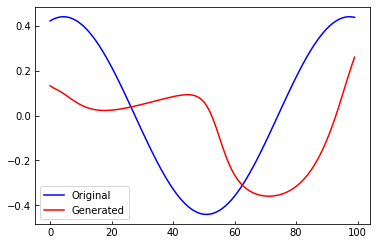

In [26]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), "b", label="Original")
plt.plot(decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


- Reconstruction is slightly better but just more overfit


### Visualize the learned results


In [27]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder, decoder)


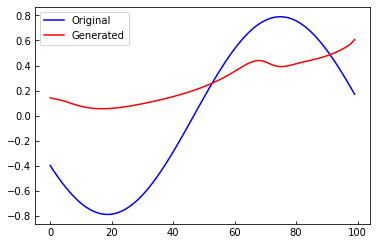

In [28]:
# plots a random example of the original and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), "b", label="Original")
plt.plot(nala_decoded_[rand].squeeze(), "r", label="Generated")
plt.legend()


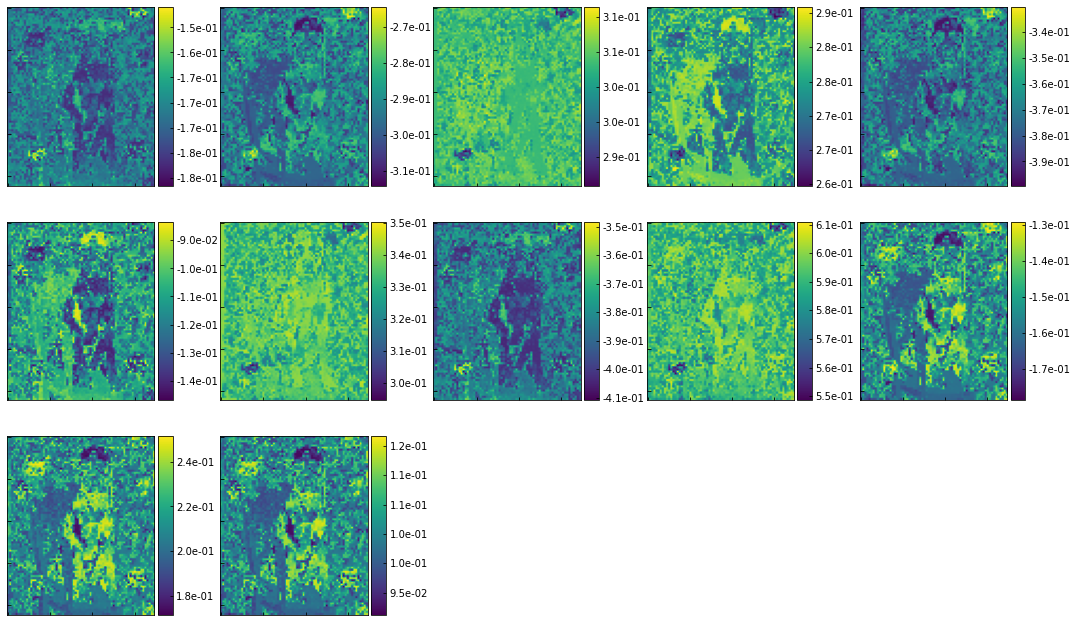

In [29]:
# Visualize the learned embeddings

embedding_maps(nala_encoded_, image)

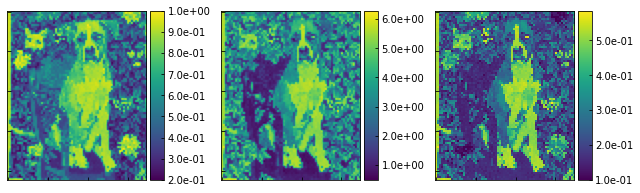

In [30]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


- **Now there are just more features but no resemblance between the parameters.**
- It would be impossible to have any resemblance to the features since it is overcomplete.


## Physics constrained neural network

### Building the model


In [31]:
class DensePhysLarger(nn.Module):
    def __init__(
        self,
        x_vector,
        model,
        dense_params=3,
        verbose=False,
        device="cuda",
        num_channels=1,
        **kwargs
    ):
        """

        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get("model_params")
        self.model = model  # (self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.sigmoid = nn.Sigmoid()
        n = 4

        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.num_channels, out_channels=8 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8 * n, out_channels=6 * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6 * n, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        self.hidden_x1_shape = self.hidden_x1(
            torch.zeros(1, self.num_channels, self.x_vector.shape[0])
        ).shape

        # fully connected block

        self.hidden_xfc = nn.Sequential(
            nn.Linear(self.hidden_x1_shape[1] * self.hidden_x1_shape[2], 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # out of size 20

        self.hidden_xfc_shape = self.hidden_xfc(
            torch.zeros(1, self.hidden_x1_shape[1] * self.hidden_x1_shape[2])
        ).shape

        # 2nd block of 1d-conv layers

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4 * n, out_channels=2 * n, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2 * n, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        self.hidden_x2_shape = self.hidden_x2(
            torch.zeros(
                (
                    self.hidden_xfc_shape[0],
                    1,
                    self.hidden_x1_shape[1] * self.hidden_x1_shape[2],
                )
            )
        ).shape

        # Flatten layer

        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear

        self.hidden_embedding = nn.Sequential(
            nn.Linear(
                self.hidden_x2_shape[1] * self.hidden_x2_shape[2]
                + self.hidden_xfc_shape[1],
                16,
            ),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.dense_params),
        )

    def forward(self, x, n=-1):

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(
            x, (x.shape[0], 1, self.hidden_x1_shape[1] * self.hidden_x1_shape[2])
        )
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.

        embedding = self.hidden_embedding(encoded)  # output is 3 parameters

        embedding = torch.reshape(embedding, (embedding.shape[0], 3, -1))

        embedding[:, 0, :] = (
            embedding[:, 0, :] * self.model.amp_sd + self.model.amp_mean
        )
        embedding[:, 1, :] = (
            embedding[:, 1, :] * self.model.phase_sd + self.model.phase_mean
        )
        embedding[:, 2, :] = (
            embedding[:, 2, :] * self.model.frequency_sd + self.model.frequency_mean
        )

        embedding = torch.reshape(embedding, (embedding.shape[0], -1))

        embedding = torch.abs(embedding)
        self.embed = embedding

        (out, _) = self.model.compute(embedding, device=self.device)

        out = torch.transpose(out, 1, 2)
        out = torch.atleast_3d(out)

        return (out.to(self.device), embedding.to(self.device))

In [32]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()

### Dataloader


In [33]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)

### Training


In [34]:
set_seeds(42)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

C:\Conda\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\engine.cpp:1000.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 0/200, recon loss = 0.34574106
--- 0.23500752449035645 seconds ---


epoch : 1/200, recon loss = 0.33094318
--- 0.22000575065612793 seconds ---


epoch : 2/200, recon loss = 0.31338234
--- 0.21299457550048828 seconds ---


epoch : 3/200, recon loss = 0.29348501
--- 0.21600770950317383 seconds ---


epoch : 4/200, recon loss = 0.27283260
--- 0.21000981330871582 seconds ---


epoch : 5/200, recon loss = 0.25353935
--- 0.209991455078125 seconds ---


epoch : 6/200, recon loss = 0.23677205
--- 0.21100950241088867 seconds ---


epoch : 7/200, recon loss = 0.22305092
--- 0.20400071144104004 seconds ---


epoch : 8/200, recon loss = 0.21273491
--- 0.20799779891967773 seconds ---


epoch : 9/200, recon loss = 0.20497591
--- 0.20199131965637207 seconds ---


epoch : 10/200, recon loss = 0.19896954
--- 0.2060089111328125 seconds ---


epoch : 11/200, recon loss = 0.19394260
--- 0.20899295806884766 seconds ---


epoch : 12/200, recon loss = 0.18948191
--- 0.21312737464904785 seconds ---


epoch : 13/200, recon loss = 0.18522813
--- 0.20400786399841309 seconds ---


epoch : 14/200, recon loss = 0.18101981
--- 0.20499849319458008 seconds ---


epoch : 15/200, recon loss = 0.17674594
--- 0.2109999656677246 seconds ---


epoch : 16/200, recon loss = 0.17229869
--- 0.20624017715454102 seconds ---


epoch : 17/200, recon loss = 0.16767639
--- 0.20913219451904297 seconds ---


epoch : 18/200, recon loss = 0.16291864
--- 0.20918512344360352 seconds ---


epoch : 19/200, recon loss = 0.15807828
--- 0.2110004425048828 seconds ---


epoch : 20/200, recon loss = 0.15324493
--- 0.2099921703338623 seconds ---


epoch : 21/200, recon loss = 0.14841766
--- 0.20607829093933105 seconds ---


epoch : 22/200, recon loss = 0.14374413
--- 0.2080378532409668 seconds ---


epoch : 23/200, recon loss = 0.13929760
--- 0.21300148963928223 seconds ---


epoch : 24/200, recon loss = 0.13521918
--- 0.21204257011413574 seconds ---


epoch : 25/200, recon loss = 0.13134453
--- 0.2063312530517578 seconds ---


epoch : 26/200, recon loss = 0.12769310
--- 0.20299744606018066 seconds ---


epoch : 27/200, recon loss = 0.12424427
--- 0.20400762557983398 seconds ---


epoch : 28/200, recon loss = 0.12109624
--- 0.2112116813659668 seconds ---


epoch : 29/200, recon loss = 0.11821198
--- 0.22533607482910156 seconds ---


epoch : 30/200, recon loss = 0.11556067
--- 0.21100068092346191 seconds ---


epoch : 31/200, recon loss = 0.11312605
--- 0.22803616523742676 seconds ---


epoch : 32/200, recon loss = 0.11083443
--- 0.2290058135986328 seconds ---


epoch : 33/200, recon loss = 0.10870192
--- 0.21813201904296875 seconds ---


epoch : 34/200, recon loss = 0.10666867
--- 0.21100187301635742 seconds ---


epoch : 35/200, recon loss = 0.10471399
--- 0.21300172805786133 seconds ---


epoch : 36/200, recon loss = 0.10281504
--- 0.20765447616577148 seconds ---


epoch : 37/200, recon loss = 0.10096469
--- 0.21700692176818848 seconds ---


epoch : 38/200, recon loss = 0.09916855
--- 0.20315790176391602 seconds ---
epoch : 39/200, recon loss = 0.09739621
--- 0.19900798797607422 seconds ---


epoch : 40/200, recon loss = 0.09567042
--- 0.20899224281311035 seconds ---
epoch : 41/200, recon loss = 0.09393662
--- 0.19700026512145996 seconds ---


epoch : 42/200, recon loss = 0.09222548
--- 0.2060074806213379 seconds ---


epoch : 43/200, recon loss = 0.09055091
--- 0.20899224281311035 seconds ---


epoch : 44/200, recon loss = 0.08890431
--- 0.20869779586791992 seconds ---


epoch : 45/200, recon loss = 0.08725998
--- 0.20800375938415527 seconds ---


epoch : 46/200, recon loss = 0.08563754
--- 0.20569896697998047 seconds ---


epoch : 47/200, recon loss = 0.08403670
--- 0.2239975929260254 seconds ---


epoch : 48/200, recon loss = 0.08244146
--- 0.20605134963989258 seconds ---


epoch : 49/200, recon loss = 0.08087762
--- 0.20798444747924805 seconds ---


epoch : 50/200, recon loss = 0.07930494
--- 0.20199942588806152 seconds ---


epoch : 51/200, recon loss = 0.07778146
--- 0.20319914817810059 seconds ---


epoch : 52/200, recon loss = 0.07622930
--- 0.20499491691589355 seconds ---


epoch : 53/200, recon loss = 0.07471360
--- 0.2080078125 seconds ---


epoch : 54/200, recon loss = 0.07321619
--- 0.20913076400756836 seconds ---


epoch : 55/200, recon loss = 0.07174289
--- 0.20704221725463867 seconds ---


epoch : 56/200, recon loss = 0.07029902
--- 0.21100306510925293 seconds ---


epoch : 57/200, recon loss = 0.06887008
--- 0.20331668853759766 seconds ---


epoch : 58/200, recon loss = 0.06748177
--- 0.20499920845031738 seconds ---


epoch : 59/200, recon loss = 0.06610590
--- 0.20618343353271484 seconds ---


epoch : 60/200, recon loss = 0.06475022
--- 0.2039933204650879 seconds ---


epoch : 61/200, recon loss = 0.06342595
--- 0.20499730110168457 seconds ---
epoch : 62/200, recon loss = 0.06211431
--- 0.19768786430358887 seconds ---


epoch : 63/200, recon loss = 0.06078772
--- 0.20400261878967285 seconds ---


epoch : 64/200, recon loss = 0.05949169
--- 0.2017042636871338 seconds ---


epoch : 65/200, recon loss = 0.05821113
--- 0.20300078392028809 seconds ---


epoch : 66/200, recon loss = 0.05693745
--- 0.2089989185333252 seconds ---


epoch : 67/200, recon loss = 0.05566555
--- 0.20900273323059082 seconds ---


epoch : 68/200, recon loss = 0.05440390
--- 0.2030026912689209 seconds ---


epoch : 69/200, recon loss = 0.05314407
--- 0.2010030746459961 seconds ---


epoch : 70/200, recon loss = 0.05188735
--- 0.20299792289733887 seconds ---


epoch : 71/200, recon loss = 0.05063043
--- 0.2067255973815918 seconds ---


epoch : 72/200, recon loss = 0.04939032
--- 0.21000885963439941 seconds ---


epoch : 73/200, recon loss = 0.04819281
--- 0.20299887657165527 seconds ---


epoch : 74/200, recon loss = 0.04701574
--- 0.20699596405029297 seconds ---
epoch : 75/200, recon loss = 0.04588420
--- 0.20069050788879395 seconds ---


epoch : 76/200, recon loss = 0.04479464
--- 0.2060244083404541 seconds ---


epoch : 77/200, recon loss = 0.04372535
--- 0.20197343826293945 seconds ---


epoch : 78/200, recon loss = 0.04269815
--- 0.21100592613220215 seconds ---


epoch : 79/200, recon loss = 0.04170063
--- 0.20100855827331543 seconds ---


epoch : 80/200, recon loss = 0.04075689
--- 0.219984769821167 seconds ---


epoch : 81/200, recon loss = 0.03984127
--- 0.21101045608520508 seconds ---


epoch : 82/200, recon loss = 0.03899212
--- 0.20999836921691895 seconds ---


epoch : 83/200, recon loss = 0.03816218
--- 0.2030010223388672 seconds ---


epoch : 84/200, recon loss = 0.03735746
--- 0.2053356170654297 seconds ---


epoch : 85/200, recon loss = 0.03661184
--- 0.21000075340270996 seconds ---
epoch : 86/200, recon loss = 0.03586183
--- 0.19900965690612793 seconds ---


epoch : 87/200, recon loss = 0.03513711
--- 0.20068573951721191 seconds ---


epoch : 88/200, recon loss = 0.03444872
--- 0.2070026397705078 seconds ---


epoch : 89/200, recon loss = 0.03376875
--- 0.20244884490966797 seconds ---


epoch : 90/200, recon loss = 0.03313003
--- 0.21300911903381348 seconds ---


epoch : 91/200, recon loss = 0.03252238
--- 0.20766782760620117 seconds ---


epoch : 92/200, recon loss = 0.03195630
--- 0.2099931240081787 seconds ---


epoch : 93/200, recon loss = 0.03139649
--- 0.208998441696167 seconds ---


epoch : 94/200, recon loss = 0.03087274
--- 0.20878887176513672 seconds ---


epoch : 95/200, recon loss = 0.03032771
--- 0.21596217155456543 seconds ---


epoch : 96/200, recon loss = 0.02981741
--- 0.22104358673095703 seconds ---


epoch : 97/200, recon loss = 0.02933747
--- 0.21833562850952148 seconds ---


epoch : 98/200, recon loss = 0.02886428
--- 0.203016996383667 seconds ---


epoch : 99/200, recon loss = 0.02837331
--- 0.20699095726013184 seconds ---


epoch : 100/200, recon loss = 0.02793451
--- 0.21999549865722656 seconds ---
epoch : 101/200, recon loss = 0.02750129
--- 0.1979961395263672 seconds ---


epoch : 102/200, recon loss = 0.02707105
--- 0.20816659927368164 seconds ---


epoch : 103/200, recon loss = 0.02667633
--- 0.20495867729187012 seconds ---


epoch : 104/200, recon loss = 0.02628049
--- 0.22114062309265137 seconds ---


epoch : 105/200, recon loss = 0.02590662
--- 0.2220458984375 seconds ---
epoch : 106/200, recon loss = 0.02555393
--- 0.18999743461608887 seconds ---


epoch : 107/200, recon loss = 0.02519607
--- 0.20913457870483398 seconds ---


epoch : 108/200, recon loss = 0.02482381
--- 0.21282267570495605 seconds ---


epoch : 109/200, recon loss = 0.02445647
--- 0.2160940170288086 seconds ---


epoch : 110/200, recon loss = 0.02407423
--- 0.2069995403289795 seconds ---


epoch : 111/200, recon loss = 0.02367110
--- 0.21704411506652832 seconds ---


epoch : 112/200, recon loss = 0.02319504
--- 0.20799517631530762 seconds ---


epoch : 113/200, recon loss = 0.02278556
--- 0.2030024528503418 seconds ---


epoch : 114/200, recon loss = 0.02236022
--- 0.20900654792785645 seconds ---


epoch : 115/200, recon loss = 0.02200377
--- 0.2109842300415039 seconds ---


epoch : 116/200, recon loss = 0.02171486
--- 0.21085476875305176 seconds ---


epoch : 117/200, recon loss = 0.02141959
--- 0.21796894073486328 seconds ---


epoch : 118/200, recon loss = 0.02120625
--- 0.21005630493164062 seconds ---


epoch : 119/200, recon loss = 0.02091130
--- 0.2079930305480957 seconds ---


epoch : 120/200, recon loss = 0.02070788
--- 0.2109982967376709 seconds ---


epoch : 121/200, recon loss = 0.02046873
--- 0.21096181869506836 seconds ---


epoch : 122/200, recon loss = 0.02025735
--- 0.21004080772399902 seconds ---


epoch : 123/200, recon loss = 0.02006443
--- 0.20620393753051758 seconds ---


epoch : 124/200, recon loss = 0.01985980
--- 0.21400856971740723 seconds ---


epoch : 125/200, recon loss = 0.01964375
--- 0.20499300956726074 seconds ---


epoch : 126/200, recon loss = 0.01948529
--- 0.21100711822509766 seconds ---


epoch : 127/200, recon loss = 0.01926242
--- 0.22000384330749512 seconds ---


epoch : 128/200, recon loss = 0.01907978
--- 0.21199870109558105 seconds ---


epoch : 129/200, recon loss = 0.01893777
--- 0.21184182167053223 seconds ---


epoch : 130/200, recon loss = 0.01875441
--- 0.209991455078125 seconds ---


epoch : 131/200, recon loss = 0.01864307
--- 0.2194199562072754 seconds ---


epoch : 132/200, recon loss = 0.01846851
--- 0.20433831214904785 seconds ---
epoch : 133/200, recon loss = 0.01834830
--- 0.1970386505126953 seconds ---


epoch : 134/200, recon loss = 0.01819122
--- 0.21126079559326172 seconds ---


epoch : 135/200, recon loss = 0.01807961
--- 0.20705580711364746 seconds ---


epoch : 136/200, recon loss = 0.01798294
--- 0.22559165954589844 seconds ---


epoch : 137/200, recon loss = 0.01781033
--- 0.21308302879333496 seconds ---


epoch : 138/200, recon loss = 0.01769738
--- 0.2080390453338623 seconds ---


epoch : 139/200, recon loss = 0.01757466
--- 0.20800423622131348 seconds ---


epoch : 140/200, recon loss = 0.01748810
--- 0.20798826217651367 seconds ---


epoch : 141/200, recon loss = 0.01731632
--- 0.20610451698303223 seconds ---


epoch : 142/200, recon loss = 0.01721316
--- 0.20949816703796387 seconds ---


epoch : 143/200, recon loss = 0.01709816
--- 0.20599818229675293 seconds ---


epoch : 144/200, recon loss = 0.01699564
--- 0.20905089378356934 seconds ---


epoch : 145/200, recon loss = 0.01687923
--- 0.23200464248657227 seconds ---
epoch : 146/200, recon loss = 0.01679383
--- 0.1999974250793457 seconds ---


epoch : 147/200, recon loss = 0.01668368
--- 0.21199464797973633 seconds ---
epoch : 148/200, recon loss = 0.01657693
--- 0.19868969917297363 seconds ---


epoch : 149/200, recon loss = 0.01650575
--- 0.20399999618530273 seconds ---


epoch : 150/200, recon loss = 0.01639202
--- 0.20499062538146973 seconds ---


epoch : 151/200, recon loss = 0.01626626
--- 0.20399761199951172 seconds ---


epoch : 152/200, recon loss = 0.01618081
--- 0.2050018310546875 seconds ---
epoch : 153/200, recon loss = 0.01609542
--- 0.19900870323181152 seconds ---


epoch : 154/200, recon loss = 0.01599815
--- 0.20299649238586426 seconds ---


epoch : 155/200, recon loss = 0.01589565
--- 0.2019939422607422 seconds ---


epoch : 156/200, recon loss = 0.01581873
--- 0.2033851146697998 seconds ---


epoch : 157/200, recon loss = 0.01575576
--- 0.20499658584594727 seconds ---


epoch : 158/200, recon loss = 0.01566448
--- 0.20300030708312988 seconds ---


epoch : 159/200, recon loss = 0.01554703
--- 0.20800995826721191 seconds ---


epoch : 160/200, recon loss = 0.01547558
--- 0.2079920768737793 seconds ---
epoch : 161/200, recon loss = 0.01537584
--- 0.19966745376586914 seconds ---


epoch : 162/200, recon loss = 0.01525916
--- 0.20299935340881348 seconds ---
epoch : 163/200, recon loss = 0.01516854
--- 0.19900083541870117 seconds ---


epoch : 164/200, recon loss = 0.01508627
--- 0.20899033546447754 seconds ---


epoch : 165/200, recon loss = 0.01500405
--- 0.20258021354675293 seconds ---


epoch : 166/200, recon loss = 0.01491275
--- 0.20562005043029785 seconds ---


epoch : 167/200, recon loss = 0.01481411
--- 0.20400786399841309 seconds ---
epoch : 168/200, recon loss = 0.01472278
--- 0.19600176811218262 seconds ---


epoch : 169/200, recon loss = 0.01465920
--- 0.2059955596923828 seconds ---
epoch : 170/200, recon loss = 0.01453096
--- 0.19999194145202637 seconds ---


epoch : 171/200, recon loss = 0.01442401
--- 0.2069990634918213 seconds ---


epoch : 172/200, recon loss = 0.01434899
--- 0.2040112018585205 seconds ---


epoch : 173/200, recon loss = 0.01423790
--- 0.20000171661376953 seconds ---
epoch : 174/200, recon loss = 0.01414539
--- 0.20799493789672852 seconds ---
epoch : 175/200, recon loss = 0.01407685
--- 0.1999950408935547 seconds ---


epoch : 176/200, recon loss = 0.01400275
--- 0.20796656608581543 seconds ---
epoch : 177/200, recon loss = 0.01395475
--- 0.19803333282470703 seconds ---


epoch : 178/200, recon loss = 0.01387623
--- 0.20708727836608887 seconds ---
epoch : 179/200, recon loss = 0.01376581
--- 0.19999194145202637 seconds ---


epoch : 180/200, recon loss = 0.01367480
--- 0.203094482421875 seconds ---
epoch : 181/200, recon loss = 0.01360377
--- 0.199263334274292 seconds ---


epoch : 182/200, recon loss = 0.01350055
--- 0.2080070972442627 seconds ---


epoch : 183/200, recon loss = 0.01342378
--- 0.2099597454071045 seconds ---


epoch : 184/200, recon loss = 0.01338361
--- 0.20203495025634766 seconds ---
epoch : 185/200, recon loss = 0.01330591
--- 0.20099902153015137 seconds ---


epoch : 186/200, recon loss = 0.01326589
--- 0.20700359344482422 seconds ---


epoch : 187/200, recon loss = 0.01315464
--- 0.21099400520324707 seconds ---


epoch : 188/200, recon loss = 0.01309153
--- 0.21500277519226074 seconds ---


epoch : 189/200, recon loss = 0.01308595
--- 0.20600533485412598 seconds ---


epoch : 190/200, recon loss = 0.01296830
--- 0.2115156650543213 seconds ---


epoch : 191/200, recon loss = 0.01290661
--- 0.2089977264404297 seconds ---


epoch : 192/200, recon loss = 0.01285434
--- 0.20099925994873047 seconds ---


epoch : 193/200, recon loss = 0.01277626
--- 0.2149670124053955 seconds ---


epoch : 194/200, recon loss = 0.01273371
--- 0.21704673767089844 seconds ---


epoch : 195/200, recon loss = 0.01265229
--- 0.21947288513183594 seconds ---


epoch : 196/200, recon loss = 0.01259758
--- 0.21600914001464844 seconds ---


epoch : 197/200, recon loss = 0.01254316
--- 0.2339930534362793 seconds ---


epoch : 198/200, recon loss = 0.01249876
--- 0.21500587463378906 seconds ---


epoch : 199/200, recon loss = 0.01243080
--- 0.21799468994140625 seconds ---


### Validation


tensor([0.4532, 3.1590, 0.4077], device='cuda:0', grad_fn=<SelectBackward0>)


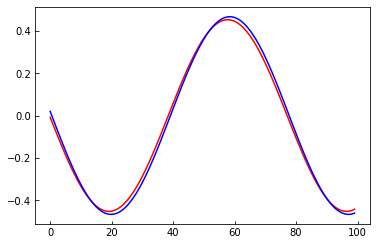

In [35]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


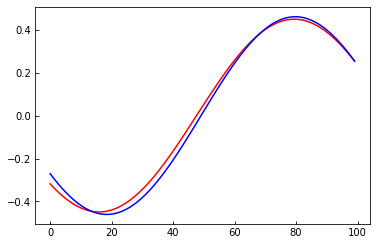

In [36]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [37]:
# removes 2pi shifts
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


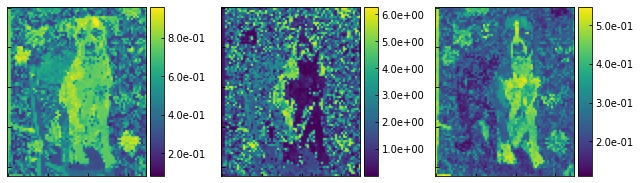

In [38]:
# Visualize the learned embeddings

embedding_maps(nala_params.detach().cpu().numpy(), image)

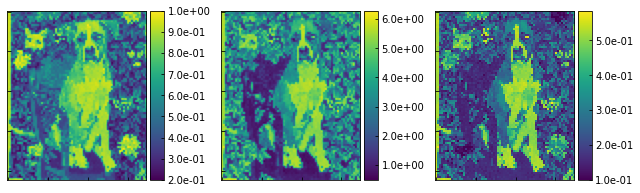

In [39]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


- **results are much closer to the underlying physics since we enforced them**
- The middle parameter is the phase. This is the hardest to learn $\rightarrow$ this makes sense


## Try with a better optimizer AdaHessian

- There are better optimizers than ADAM that use second-order information


In [40]:
"""
Created on Sun Feb 26 16:34:00 2021
@author: Amir Gholami
@coauthor: David Samuel
"""

import numpy as np
import torch


class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(
        self,
        params,
        lr=0.1,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0.0,
        hessian_power=1.0,
        update_each=1,
        n_samples=1,
        average_conv_kernel=False,
    ):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            hessian_power=hessian_power,
        )
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (
            p for group in self.param_groups for p in group["params"] if p.requires_grad
        )

    def zero_hessian(self):
        """
        Zeros out the accumulated hessian traces.
        """

        for p in self.get_params():
            if (
                not isinstance(p.hess, float)
                and self.state[p]["hessian step"] % self.update_each == 0
            ):
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if (
                self.state[p]["hessian step"] % self.update_each == 0
            ):  # compute the trace only for each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if (
            self.generator.device != params[0].device
        ):  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [
                torch.randint(0, 2, p.size(), generator=self.generator, device=p.device)
                * 2.0
                - 1.0
                for p in params
            ]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(
                grads,
                params,
                grad_outputs=zs,
                only_inputs=True,
                retain_graph=i < self.n_samples - 1,
            )
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += (
                    h_z * z / self.n_samples
                )  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = (
                        torch.abs(p.hess)
                        .mean(dim=[2, 3], keepdim=True)
                        .expand_as(p.hess)
                        .clone()
                    )

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group["lr"] * group["weight_decay"])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of gradient values
                    state["exp_hessian_diag_sq"] = torch.zeros_like(
                        p.data
                    )  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = (
                    state["exp_avg"],
                    state["exp_hessian_diag_sq"],
                )
                beta1, beta2 = group["betas"]
                state["step"] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(
                    p.hess, p.hess, value=1 - beta2
                )

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                k = group["hessian_power"]
                denom = (
                    (exp_hessian_diag_sq / bias_correction2)
                    .pow_(k / 2)
                    .add_(group["eps"])
                )

                # make update
                step_size = group["lr"] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

### Builds the model


In [41]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(
    x_vector, constructor, dense_params=3, model_params=3, verbose=False
)

if torch.cuda.is_available():
    model.cuda()

### Dataloader


In [42]:
# builds the dataloader

dataloader = DataLoader(
    torch.transpose(spectra_full, 1, 2), batch_size=512, shuffle=True, num_workers=0
)

### Training


In [43]:
set_seeds(42)

loss_func = torch.nn.MSELoss()

# Use AdaHessian

optimizer = AdaHessian(model.parameters(), lr=0.1)

epochs = 200

for epoch in range(epochs):
    start_time = time.time()

    train_loss = 0.0
    total_num = 0

    model.train()

    for train_batch in dataloader:
        pred, _ = model(train_batch.cuda())

        optimizer.zero_grad()

        loss = loss_func(train_batch.cuda(), pred)
        loss.backward(create_graph=True)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]

        optimizer.step()

    train_loss /= total_num

    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0/200, recon loss = 0.20526965
--- 1.083345651626587 seconds ---


epoch : 1/200, recon loss = 0.13739116
--- 1.0673527717590332 seconds ---


epoch : 2/200, recon loss = 0.12782625
--- 1.043203592300415 seconds ---


epoch : 3/200, recon loss = 0.11854326
--- 1.0706591606140137 seconds ---


epoch : 4/200, recon loss = 0.10321694
--- 1.064610242843628 seconds ---


epoch : 5/200, recon loss = 0.09047912
--- 1.0762226581573486 seconds ---


epoch : 6/200, recon loss = 0.07436261
--- 1.0709617137908936 seconds ---


epoch : 7/200, recon loss = 0.05796502
--- 1.0728590488433838 seconds ---


epoch : 8/200, recon loss = 0.04443812
--- 1.0668137073516846 seconds ---


epoch : 9/200, recon loss = 0.03451002
--- 1.0996503829956055 seconds ---


epoch : 10/200, recon loss = 0.02948848
--- 1.0909044742584229 seconds ---


epoch : 11/200, recon loss = 0.02639160
--- 1.0698745250701904 seconds ---


epoch : 12/200, recon loss = 0.02391856
--- 1.0953550338745117 seconds ---


epoch : 13/200, recon loss = 0.02209671
--- 1.0820238590240479 seconds ---


epoch : 14/200, recon loss = 0.02079287
--- 1.2178149223327637 seconds ---


epoch : 15/200, recon loss = 0.01982752
--- 1.3193333148956299 seconds ---


epoch : 16/200, recon loss = 0.01897771
--- 1.1655056476593018 seconds ---


epoch : 17/200, recon loss = 0.01868618
--- 1.1620161533355713 seconds ---


epoch : 18/200, recon loss = 0.01755036
--- 1.1480226516723633 seconds ---


epoch : 19/200, recon loss = 0.01687329
--- 1.146524429321289 seconds ---


epoch : 20/200, recon loss = 0.01626821
--- 1.1655406951904297 seconds ---


epoch : 21/200, recon loss = 0.01587514
--- 1.12800931930542 seconds ---


epoch : 22/200, recon loss = 0.01534458
--- 1.0800156593322754 seconds ---


epoch : 23/200, recon loss = 0.01501700
--- 1.0730085372924805 seconds ---


epoch : 24/200, recon loss = 0.01451476
--- 1.071030855178833 seconds ---


epoch : 25/200, recon loss = 0.01436930
--- 1.470430612564087 seconds ---


epoch : 26/200, recon loss = 0.01426288
--- 1.1932249069213867 seconds ---


epoch : 27/200, recon loss = 0.01365905
--- 1.1995761394500732 seconds ---


epoch : 28/200, recon loss = 0.01334308
--- 1.13946533203125 seconds ---


epoch : 29/200, recon loss = 0.01321950
--- 1.092041015625 seconds ---


epoch : 30/200, recon loss = 0.01299400
--- 1.1030521392822266 seconds ---


epoch : 31/200, recon loss = 0.01255491
--- 1.1340129375457764 seconds ---


epoch : 32/200, recon loss = 0.01241236
--- 1.1155054569244385 seconds ---


epoch : 33/200, recon loss = 0.01209807
--- 1.1030216217041016 seconds ---


epoch : 34/200, recon loss = 0.01187063
--- 1.0969998836517334 seconds ---


epoch : 35/200, recon loss = 0.01180440
--- 1.2770195007324219 seconds ---


epoch : 36/200, recon loss = 0.01153767
--- 1.1130008697509766 seconds ---


epoch : 37/200, recon loss = 0.01127145
--- 1.0925145149230957 seconds ---


epoch : 38/200, recon loss = 0.01120854
--- 1.0386910438537598 seconds ---


epoch : 39/200, recon loss = 0.01095401
--- 1.0600152015686035 seconds ---


epoch : 40/200, recon loss = 0.01077170
--- 1.1400172710418701 seconds ---


epoch : 41/200, recon loss = 0.01054296
--- 1.1170389652252197 seconds ---


epoch : 42/200, recon loss = 0.01101076
--- 1.0821514129638672 seconds ---


epoch : 43/200, recon loss = 0.01044852
--- 1.1860120296478271 seconds ---


epoch : 44/200, recon loss = 0.01044315
--- 1.2637429237365723 seconds ---


epoch : 45/200, recon loss = 0.01006699
--- 1.0436387062072754 seconds ---


epoch : 46/200, recon loss = 0.00986989
--- 1.0401813983917236 seconds ---


epoch : 47/200, recon loss = 0.00981965
--- 1.0355689525604248 seconds ---


epoch : 48/200, recon loss = 0.00958605
--- 1.0677917003631592 seconds ---


epoch : 49/200, recon loss = 0.00946511
--- 1.0625231266021729 seconds ---


epoch : 50/200, recon loss = 0.00935563
--- 1.07234787940979 seconds ---


epoch : 51/200, recon loss = 0.01006500
--- 1.0795094966888428 seconds ---


epoch : 52/200, recon loss = 0.00985975
--- 1.0760245323181152 seconds ---


epoch : 53/200, recon loss = 0.00932037
--- 1.0775127410888672 seconds ---


epoch : 54/200, recon loss = 0.00889509
--- 1.0560293197631836 seconds ---


epoch : 55/200, recon loss = 0.00875717
--- 1.0670228004455566 seconds ---


epoch : 56/200, recon loss = 0.00867611
--- 1.079007625579834 seconds ---


epoch : 57/200, recon loss = 0.00902518
--- 1.0315091609954834 seconds ---


epoch : 58/200, recon loss = 0.00849642
--- 1.067000389099121 seconds ---


epoch : 59/200, recon loss = 0.00836360
--- 1.070012092590332 seconds ---


epoch : 60/200, recon loss = 0.00823630
--- 1.0610103607177734 seconds ---


epoch : 61/200, recon loss = 0.00813689
--- 1.0820071697235107 seconds ---


epoch : 62/200, recon loss = 0.00819881
--- 1.0820105075836182 seconds ---


epoch : 63/200, recon loss = 0.00878822
--- 1.0867738723754883 seconds ---


epoch : 64/200, recon loss = 0.00922335
--- 1.0752873420715332 seconds ---


epoch : 65/200, recon loss = 0.00867164
--- 1.0770063400268555 seconds ---


epoch : 66/200, recon loss = 0.00821315
--- 1.0673120021820068 seconds ---


epoch : 67/200, recon loss = 0.00814663
--- 1.0762112140655518 seconds ---


epoch : 68/200, recon loss = 0.00825924
--- 1.0734682083129883 seconds ---


epoch : 69/200, recon loss = 0.00802974
--- 1.172471284866333 seconds ---


epoch : 70/200, recon loss = 0.00779212
--- 1.0953478813171387 seconds ---


epoch : 71/200, recon loss = 0.00747777
--- 1.109062910079956 seconds ---


epoch : 72/200, recon loss = 0.00734167
--- 1.0435409545898438 seconds ---


epoch : 73/200, recon loss = 0.00737135
--- 1.0677106380462646 seconds ---


epoch : 74/200, recon loss = 0.00772026
--- 1.0642919540405273 seconds ---


epoch : 75/200, recon loss = 0.00720435
--- 1.098451852798462 seconds ---


epoch : 76/200, recon loss = 0.00758679
--- 1.0919198989868164 seconds ---


epoch : 77/200, recon loss = 0.00710593
--- 1.0528452396392822 seconds ---


epoch : 78/200, recon loss = 0.00724899
--- 1.0833525657653809 seconds ---


epoch : 79/200, recon loss = 0.00682783
--- 1.0859904289245605 seconds ---


epoch : 80/200, recon loss = 0.00670120
--- 1.0864288806915283 seconds ---


epoch : 81/200, recon loss = 0.00703554
--- 1.0255155563354492 seconds ---


epoch : 82/200, recon loss = 0.00675994
--- 1.0443446636199951 seconds ---


epoch : 83/200, recon loss = 0.00637479
--- 1.0371360778808594 seconds ---


epoch : 84/200, recon loss = 0.00691859
--- 1.0465271472930908 seconds ---


epoch : 85/200, recon loss = 0.00663811
--- 1.3861987590789795 seconds ---


epoch : 86/200, recon loss = 0.00669824
--- 1.0629949569702148 seconds ---


epoch : 87/200, recon loss = 0.00651791
--- 1.0728459358215332 seconds ---


epoch : 88/200, recon loss = 0.00661808
--- 1.0750162601470947 seconds ---


epoch : 89/200, recon loss = 0.00618707
--- 1.15144681930542 seconds ---


epoch : 90/200, recon loss = 0.00674573
--- 1.132087230682373 seconds ---


epoch : 91/200, recon loss = 0.00634164
--- 1.0591728687286377 seconds ---


epoch : 92/200, recon loss = 0.00626949
--- 1.0590224266052246 seconds ---


epoch : 93/200, recon loss = 0.00621492
--- 1.0953989028930664 seconds ---


epoch : 94/200, recon loss = 0.00604116
--- 1.2119741439819336 seconds ---


epoch : 95/200, recon loss = 0.00578017
--- 1.1119604110717773 seconds ---


epoch : 96/200, recon loss = 0.00528070
--- 1.078010082244873 seconds ---


epoch : 97/200, recon loss = 0.00560600
--- 1.052999496459961 seconds ---


epoch : 98/200, recon loss = 0.00531720
--- 1.2792303562164307 seconds ---


epoch : 99/200, recon loss = 0.00528165
--- 1.0400257110595703 seconds ---


epoch : 100/200, recon loss = 0.00569718
--- 1.0578067302703857 seconds ---


epoch : 101/200, recon loss = 0.00609801
--- 1.0708980560302734 seconds ---


epoch : 102/200, recon loss = 0.00570455
--- 1.1720695495605469 seconds ---


epoch : 103/200, recon loss = 0.00545805
--- 1.0440082550048828 seconds ---


epoch : 104/200, recon loss = 0.00519624
--- 1.0945098400115967 seconds ---


epoch : 105/200, recon loss = 0.00523496
--- 1.0895330905914307 seconds ---


epoch : 106/200, recon loss = 0.00497242
--- 1.065014362335205 seconds ---


epoch : 107/200, recon loss = 0.00519945
--- 1.0460083484649658 seconds ---


epoch : 108/200, recon loss = 0.00463584
--- 1.073024034500122 seconds ---


epoch : 109/200, recon loss = 0.00438288
--- 1.111025094985962 seconds ---


epoch : 110/200, recon loss = 0.00458408
--- 1.0917596817016602 seconds ---


epoch : 111/200, recon loss = 0.00463187
--- 1.114292860031128 seconds ---


epoch : 112/200, recon loss = 0.00443378
--- 1.0856835842132568 seconds ---


epoch : 113/200, recon loss = 0.00436009
--- 1.1650218963623047 seconds ---


epoch : 114/200, recon loss = 0.00467339
--- 1.1615874767303467 seconds ---


epoch : 115/200, recon loss = 0.00432748
--- 1.148338794708252 seconds ---


epoch : 116/200, recon loss = 0.00460212
--- 1.1499841213226318 seconds ---


epoch : 117/200, recon loss = 0.00459990
--- 1.1489319801330566 seconds ---


epoch : 118/200, recon loss = 0.00481568
--- 1.0726866722106934 seconds ---


epoch : 119/200, recon loss = 0.00501926
--- 1.0415151119232178 seconds ---


epoch : 120/200, recon loss = 0.00474176
--- 1.044121503829956 seconds ---


epoch : 121/200, recon loss = 0.00429731
--- 1.0459496974945068 seconds ---


epoch : 122/200, recon loss = 0.00418878
--- 1.076171875 seconds ---


epoch : 123/200, recon loss = 0.00412989
--- 1.051729440689087 seconds ---


epoch : 124/200, recon loss = 0.00409063
--- 1.0446438789367676 seconds ---


epoch : 125/200, recon loss = 0.00419073
--- 1.317875623703003 seconds ---


epoch : 126/200, recon loss = 0.00412919
--- 1.101003885269165 seconds ---


epoch : 127/200, recon loss = 0.00411023
--- 1.1108191013336182 seconds ---


epoch : 128/200, recon loss = 0.00402640
--- 1.1070067882537842 seconds ---


epoch : 129/200, recon loss = 0.00507844
--- 1.0455305576324463 seconds ---


epoch : 130/200, recon loss = 0.00553475
--- 1.0780072212219238 seconds ---


epoch : 131/200, recon loss = 0.00416847
--- 1.0619995594024658 seconds ---


epoch : 132/200, recon loss = 0.00408905
--- 1.0590004920959473 seconds ---


epoch : 133/200, recon loss = 0.00396713
--- 1.331831693649292 seconds ---


epoch : 134/200, recon loss = 0.00443820
--- 1.089000940322876 seconds ---


epoch : 135/200, recon loss = 0.00389224
--- 1.2536420822143555 seconds ---


epoch : 136/200, recon loss = 0.00444392
--- 1.0659596920013428 seconds ---


epoch : 137/200, recon loss = 0.00401122
--- 1.0619590282440186 seconds ---


epoch : 138/200, recon loss = 0.00401013
--- 1.2204227447509766 seconds ---


epoch : 139/200, recon loss = 0.00385270
--- 1.3458333015441895 seconds ---


epoch : 140/200, recon loss = 0.00376991
--- 1.143522024154663 seconds ---


epoch : 141/200, recon loss = 0.00417260
--- 1.1420187950134277 seconds ---


epoch : 142/200, recon loss = 0.00387415
--- 1.0470123291015625 seconds ---


epoch : 143/200, recon loss = 0.00371486
--- 1.0351436138153076 seconds ---


epoch : 144/200, recon loss = 0.00445840
--- 1.0335111618041992 seconds ---


epoch : 145/200, recon loss = 0.00467545
--- 1.0740330219268799 seconds ---


epoch : 146/200, recon loss = 0.00483546
--- 1.1135153770446777 seconds ---


epoch : 147/200, recon loss = 0.00462108
--- 1.0310108661651611 seconds ---


epoch : 148/200, recon loss = 0.00444718
--- 1.0289123058319092 seconds ---


epoch : 149/200, recon loss = 0.00504854
--- 1.0785856246948242 seconds ---


epoch : 150/200, recon loss = 0.00570093
--- 1.0587153434753418 seconds ---


epoch : 151/200, recon loss = 0.00499210
--- 1.1097984313964844 seconds ---


epoch : 152/200, recon loss = 0.00474820
--- 1.1171507835388184 seconds ---


epoch : 153/200, recon loss = 0.00429697
--- 1.0577483177185059 seconds ---


epoch : 154/200, recon loss = 0.00417946
--- 1.0289735794067383 seconds ---


epoch : 155/200, recon loss = 0.00425317
--- 1.0539779663085938 seconds ---


epoch : 156/200, recon loss = 0.00435145
--- 1.0226662158966064 seconds ---


epoch : 157/200, recon loss = 0.00463348
--- 1.031801462173462 seconds ---


epoch : 158/200, recon loss = 0.00394153
--- 1.0289196968078613 seconds ---


epoch : 159/200, recon loss = 0.00380366
--- 1.0804555416107178 seconds ---


epoch : 160/200, recon loss = 0.00402936
--- 1.2686195373535156 seconds ---


epoch : 161/200, recon loss = 0.00365112
--- 1.091965913772583 seconds ---


epoch : 162/200, recon loss = 0.00394416
--- 1.115626573562622 seconds ---


epoch : 163/200, recon loss = 0.00410108
--- 1.091942310333252 seconds ---


epoch : 164/200, recon loss = 0.00375785
--- 1.0615594387054443 seconds ---


epoch : 165/200, recon loss = 0.00383349
--- 1.0232088565826416 seconds ---


epoch : 166/200, recon loss = 0.00364952
--- 1.071964979171753 seconds ---


epoch : 167/200, recon loss = 0.00348812
--- 1.0111479759216309 seconds ---


epoch : 168/200, recon loss = 0.00335469
--- 1.0667665004730225 seconds ---


epoch : 169/200, recon loss = 0.00364010
--- 1.0996840000152588 seconds ---


epoch : 170/200, recon loss = 0.00388290
--- 1.0680177211761475 seconds ---


epoch : 171/200, recon loss = 0.00359374
--- 1.0370159149169922 seconds ---


epoch : 172/200, recon loss = 0.00344462
--- 1.0846848487854004 seconds ---


epoch : 173/200, recon loss = 0.00325264
--- 1.0342254638671875 seconds ---


epoch : 174/200, recon loss = 0.00351823
--- 1.0433053970336914 seconds ---


epoch : 175/200, recon loss = 0.00371351
--- 1.0997090339660645 seconds ---


epoch : 176/200, recon loss = 0.00474455
--- 1.1001601219177246 seconds ---


epoch : 177/200, recon loss = 0.00352304
--- 1.1044354438781738 seconds ---


epoch : 178/200, recon loss = 0.00368994
--- 1.1180968284606934 seconds ---


epoch : 179/200, recon loss = 0.00374937
--- 1.0591673851013184 seconds ---


epoch : 180/200, recon loss = 0.00343042
--- 1.077392578125 seconds ---


epoch : 181/200, recon loss = 0.00348317
--- 1.0312790870666504 seconds ---


epoch : 182/200, recon loss = 0.00319601
--- 1.0401802062988281 seconds ---


epoch : 183/200, recon loss = 0.00365811
--- 1.0483930110931396 seconds ---


epoch : 184/200, recon loss = 0.00341645
--- 1.0322387218475342 seconds ---


epoch : 185/200, recon loss = 0.00391161
--- 1.0440402030944824 seconds ---


epoch : 186/200, recon loss = 0.00382884
--- 1.0965471267700195 seconds ---


epoch : 187/200, recon loss = 0.00368251
--- 1.097320556640625 seconds ---


epoch : 188/200, recon loss = 0.00323839
--- 1.0334491729736328 seconds ---


epoch : 189/200, recon loss = 0.00312336
--- 1.0480718612670898 seconds ---


epoch : 190/200, recon loss = 0.00333612
--- 1.0563039779663086 seconds ---


epoch : 191/200, recon loss = 0.00326259
--- 1.0549976825714111 seconds ---


epoch : 192/200, recon loss = 0.00316171
--- 1.12684965133667 seconds ---


epoch : 193/200, recon loss = 0.00320501
--- 1.0306603908538818 seconds ---


epoch : 194/200, recon loss = 0.00313467
--- 1.0618469715118408 seconds ---


epoch : 195/200, recon loss = 0.00334962
--- 1.0457274913787842 seconds ---


epoch : 196/200, recon loss = 0.00348116
--- 1.0805318355560303 seconds ---


epoch : 197/200, recon loss = 0.00328243
--- 1.0865435600280762 seconds ---


epoch : 198/200, recon loss = 0.00309600
--- 1.0860247611999512 seconds ---


epoch : 199/200, recon loss = 0.00350014
--- 1.0609993934631348 seconds ---


### Visualization


tensor([0.4940, 3.1169, 0.4060], device='cuda:0', grad_fn=<SelectBackward0>)


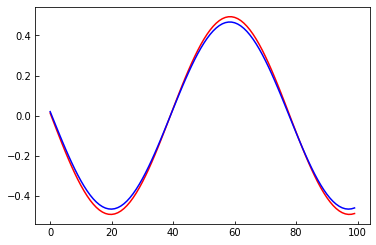

In [44]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0, 272)
plt.plot(spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, 0, :], "b")
print(params[rand])


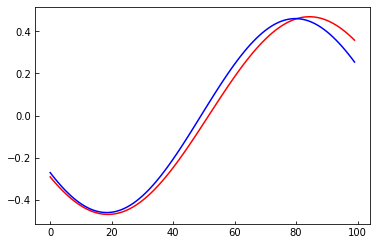

In [45]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2, 1).cuda())
rand = np.random.randint(0, nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand, 0, :].detach().cpu().numpy(), "r")
plt.plot(nala_spectra[rand, :, 0], "b")


In [46]:
nala_params[:, 1] = nala_params[:, 1] % 2 * np.pi


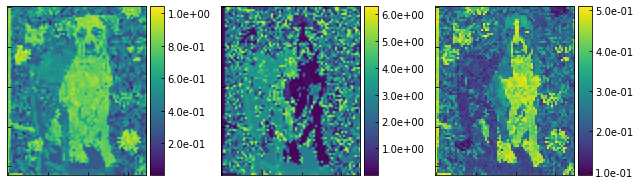

In [47]:
# Visualize the learned embeddings

embedding_maps(nala_params.detach().cpu().numpy(), image)

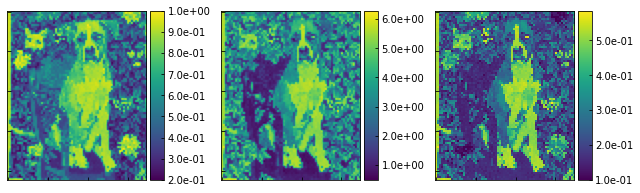

In [48]:
# visualize the actual RGB channels.

embedding_maps(_nala_params.reshape(-1, 3), image)


This is clearly the best result

- It is quite impressive that we can build a feed forward model to fit data to complex functions
- This is actually a very hard task for a neural network as frequency and phase are something that cannot be learned easily in convolutions
